# Exploring many CNN models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv2D, MaxPooling2D, Dense, Conv1D, Dropout
from keras.layers import MaxPooling1D, Flatten, Embedding, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
import spacy
import nltk
import en_core_web_md
from tensorflow import keras

sns.set(style='whitegrid')

Using TensorFlow backend.


In [2]:
ign_df = pd.read_pickle('ign_data/ign_data_pass_three.pkl')

ign_df = ign_df.loc[ign_df['review_score']!='null']
ign_df.reset_index(drop=True)

print(ign_df.shape)
ign_df.head()

(11072, 19)


links  \
1  https://www.ign.com/articles/2011/07/19/warham...   
2  https://www.ign.com/articles/2011/07/20/call-o...   
3  https://www.ign.com/articles/2011/07/20/captai...   
4  https://www.ign.com/articles/2011/07/20/quiz-c...   
5  https://www.ign.com/articles/2011/07/20/limbo-...   

                                   rough_review_body  \
1  \u003csection class=\"article-page\"\u003e\u00...   
2  \u003csection class=\"article-page\"\u003eThe ...   
3  \u003csection class=\"article-page\"\u003eThe ...   
4  \u003csection class=\"article-page\"\u003e\u00...   
5  \u003csection class=\"article-page\"\u003eVide...   

                                 cleaned_review_body  \
1     'Warhammer 40K: Kill Team might be unfortun...   
2   The Call of Juarez franchise always intereste...   
3   The majority of movie games are just awful. S...   
4     'Quiz Climber, from Buzz! developer   'Rele...   
5   Video games are an art form made up of visual...   

                                review_summary_rough review_score  \
1  "And \"also-ran\" hangs all over Warhammer 40K...          6.5   
2  "Call of Juarez: The Cartel is a poor change o...          4.5   
3  "Captain America: Super Soldier is a mediocre ...          5.5   
4  "Ultimately, Quiz Climber is just a little too...          6.5   
5  "Limbo is an incredible achievement. Very few ...            9   

                                                tags  \
1  :["review","blogroll","event-essentials","hot"...   
2  :["review","blogroll","call-of-juarez-the-cart...   
3  :["review","blogroll","legacy","wii","games","...   
4  :["review","blogroll","games","legacy","wirele...   
5  :["review","games","legacy","limbo","platforme...   

                               categories             modified_date  \
1  :["ign","ps3","xbox-360","xbox-live"],  2011-10-18T05:59:32+0000   
2         :["ign","pc","ps3","xbox-360"],  2011-10-18T06:02:02+0000   
3                         :["ign","wii"],  2011-10-18T06:02:20+0000   
4                    :["ign","wireless"],  2011-10-18T06:07:06+0000   
5                          :["pc","ps3"],  2011-10-18T06:07:21+0000   

             published_date         author_name  \
1  2011-07-19T19:47:00+0000       "Arthur Gies"   
2  2011-07-20T00:14:00+0000  "Anthony Gallegos"   
3  2011-07-20T00:43:00+0000      "Audrey Drake"   
4  2011-07-20T21:44:00+0000      "Justin Davis"   
5  2011-07-20T22:29:00+0000   "Daemon Hatfield"   

                                            tag_list  \
1  [review, blogroll, event-essentials, hot, lega...   
2  [review, blogroll, call-of-juarez-the-cartel, ...   
3  [review, blogroll, legacy, wii, games, captain...   
4  [review, blogroll, games, legacy, wireless, qu...   
5  [review, games, legacy, limbo, platformer, pla...   

                     categories_list  \
1  [ign, ps3, xbox-360, xbox-live, ]   
2         [ign, pc, ps3, xbox-360, ]   
3                       [ign, wii, ]   
4                  [ign, wireless, ]   
5                        [pc, ps3, ]   

                                  review_title  \
1            "Warhammer 40K: Kill Team Review"   
2          "Call of Juarez: The Cartel Review"   
3  "Captain America: Super Soldier Wii Review"   
4                        "Quiz Climber Review"   
5                               "Limbo Review"   

                                  review_body_corpus  review_score_float  \
1     warhammer 40k kill team might be unfortunat...                 6.5   
2   the call of juarez franchise always intereste...                 4.5   
3   the majority of movie games are just awful st...                 5.5   
4     quiz climber from buzz developer   relentle...                 6.5   
5   video games are an art form made up of visual...                 9.0   

   number_character_review  number_words_review  polarity  subjectivity  
1                     3705                  642  0.062923      0.433371  
2                     3770                  648 -0.016471      0.4

In [3]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)

test_size = 0.2

ign_data = ign_df['cleaned_review_body'].values
ign_scores = ign_df['review_score_float'].values 
ign_standard_values = ign_scores/10.0

data_train, data_validation, target_train, target_validation = train_test_split(ign_data, 
                                                                                ign_standard_values, 
                                                                                test_size=test_size, 
                                                                                random_state=42)

In [4]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)
data_train_cv = vectorizer.fit_transform(data_train)
data_valid_cv = vectorizer.transform(data_validation)

In [5]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

# print(len(vectorizer.get_feature_names()))

def to_sequence(tokenizer, preprocessor, index, text):
    
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    
    return indexes

print(to_sequence(tokenize, preprocess, word2idx, 'This is an important test!'))

[2218, 4437]


In [6]:
data_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_train]
data_valid_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_validation]

# padding sequences
MAX_SEQ_LENGTH = len(max(data_train_sequences, key=len))
if len(max(data_valid_sequences, key=len)) > MAX_SEQ_LENGTH:
    MAX_SEQ_LENGTH = len(max(data_valid_sequences, key=len))
    
N_FEATURES = len(vectorizer.get_feature_names())

# a correction I'm putting in, because MAX Length changes otherwise based on training (need to change logic on this)
MAX_SEQ_LENGTH = 2704 # is the length for some models, may have to change
print(MAX_SEQ_LENGTH)
print(N_FEATURES)

data_train_sequences = pad_sequences(data_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
data_valid_sequences = pad_sequences(data_valid_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

print(data_train_sequences[0])
# print(vectorizer.get_feature_names())
# print(vectorizer.build_tokenizer())

2704
5000
[5000 5000 5000 ... 2851  481  876]


In [7]:
def cnn_nlp_layer_unit(model, conv_units, kernel_size, pool_size, dropout, regularizer):
    
    model.add(Conv1D(filters=conv_units, kernel_size=kernel_size, 
                     activation='relu', padding='same', kernel_regularizer=regularizer))
    model.add(MaxPooling1D(pool_size=pool_size, padding='same'))
    model.add(Dropout(dropout))
    
    return model

In [8]:
def cnn_nlp_model_blueprint(conv_units, kernel_size, pool_size, 
                            dropout, initial_output=64, regularizer=None):
    
    model = Sequential()
    
    num_layers = len(conv_units)
    
    model.add(Embedding(len(vectorizer.get_feature_names())+1, 
                        output_dim=initial_output, 
                        input_length=MAX_SEQ_LENGTH))
    for i in range(num_layers):
        model = cnn_nlp_layer_unit(model=model, 
                                   conv_units=conv_units[i], 
                                   kernel_size=kernel_size, 
                                   pool_size=pool_size, 
                                   dropout=dropout, 
                                   regularizer=regularizer)
    
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    
    # output layer
    model.add(Dense(units=1, kernel_initializer='normal'))
    
    return model

In [9]:
def get_model_summary(model):
    stream = io.StringIO()
    model.summary(print_fn=lambda x: stream.write(x+'\n'))
    summary_string = stream.getvalue()
    stream.close()
    return summary_string

In [12]:
def build_test_run_models(epochs, batch_size, 
                          previous_completed_runs=0, 
                          conv_units=[[2**8, 2**7]], 
                          output_dims=[16], 
                          kernel_sizes=[3], 
                          pool_sizes=[3], 
                          dropouts=[0.3], 
                          dir_base='cnn_scoring_models', 
                          save=False):
    # want to iterate over several models with varying hyperparameters
    
    EPOCH = epochs
    BATCH = batch_size
    
    # define simple parameter space 
    conv_units = conv_units
    output_dims = output_dims
    num_models = len(conv_units)
    kernel_sizes = kernel_sizes
    pool_sizes = pool_sizes
    dropouts = dropouts
    
    previous_iterations = previous_completed_runs # have to set everytime
    i = 0
    for model_units in conv_units:
        
        for kernel_size in kernel_sizes:
            
            for pool_size in pool_sizes:
                
                for dropout in dropouts:
                    
                    for output_dim in output_dims:
                    
                        print('current model iteration = ', i)
                    
                        if i < previous_iterations:
                            i += 1
                            continue
                    
                        test_model = cnn_nlp_model_blueprint(conv_units=model_units, 
                                                         kernel_size=kernel_size, 
                                                         pool_size=pool_size, 
                                                         dropout=dropout, 
                                                         initial_output=output_dim)
        
                        test_model.compile(loss='mse', 
                                       optimizer='adam', 
                                       metrics=['mae', 'mse'])
        
                        test_model.fit(data_train_sequences[:-500], target_train[:-500], 
                                   epochs=EPOCH, batch_size=BATCH, verbose=0, 
                                   validation_data=(data_train_sequences[-500:], target_train[-500:]))
        
                        # consider saving the model here
                        saving_dir = '{}/model_{}/'.format(dir_base, i)
                
                        writing_text = get_model_summary(test_model)
                        writing_text += '\n'
                        writing_text += 'model parameters\nconvolutional units = {}\n'.format(model_units)
                        writing_text += 'kernel size = {}\npooling size = {}\ndropout = {}\n'.format(kernel_size, 
                                                                                               pool_size, 
                                                                                               dropout)
                        writing_text += 'output dimensions = {}\n'.format(output_dim)
                        writing_text += 'number of epochs = {}\n'.format(EPOCH)
                        writing_text += 'batch size = {}'.format(BATCH)
                    
                        if not os.path.exists(dir_base):
                            os.mkdir(dir_base)
                    
                        if not os.path.exists(saving_dir):
                            os.mkdir(saving_dir)
        
                        mse_file = saving_dir + 'mse.jpg'
                        mae_file = saving_dir + 'mae.jpg'
                        log_mse_file = saving_dir + 'log_mse.jpg'
                        model_info_name = saving_dir + 'model_info.txt'
                    
                        model_info_write = open(model_info_name, mode='w')
                        model_info_write.write(writing_text)
                        model_info_write.close()
        
                        plt.plot(test_model.history.history['val_mse'], label='val')
                        plt.plot(test_model.history.history['mse'], label='train')
                        plt.title('mse')
                        plt.legend()
                        plt.savefig(fname=mse_file, dpi=100)
                        plt.show()

                        plt.plot(test_model.history.history['val_mae'], label='val')
                        plt.plot(test_model.history.history['mae'], label='train')
                        plt.title('mae')
                        plt.legend()
                        plt.savefig(fname=mae_file, dpi=100)
                        plt.show()
                    
                        plt.plot(test_model.history.history['val_mse'], label='validation')
                        plt.plot(test_model.history.history['mse'], label='training')
                        plt.yscale('log')
                        plt.legend()
                        plt.title('mse')
                        plt.savefig(fname=log_mse_file, dpi=100)
                        plt.show()
            
                        if save:
                            save_path='scoring_models/'
                            test_model.save(save_path+dir_base+'_'+str(i)+'.h5')
                            
                        i += 1
        
                        K.clear_session()
    
    return

current model iteration =  0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.




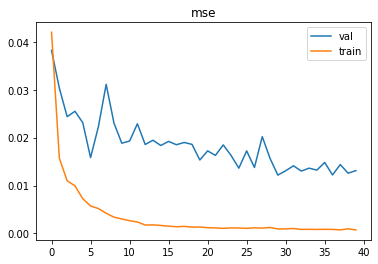

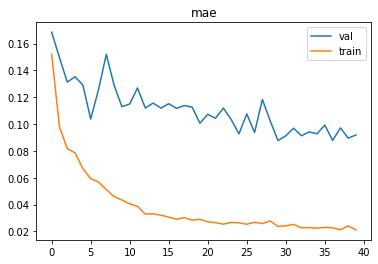

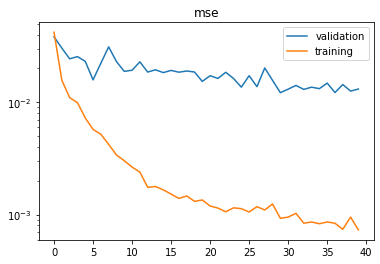

current model iteration =  1


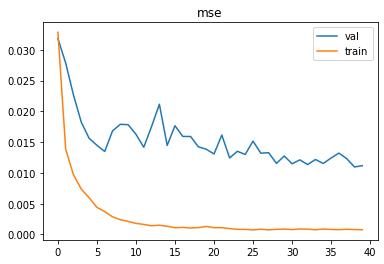

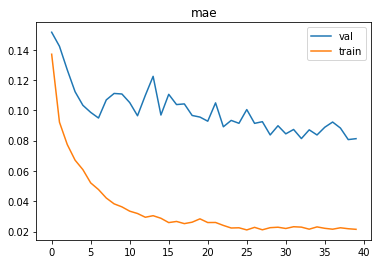

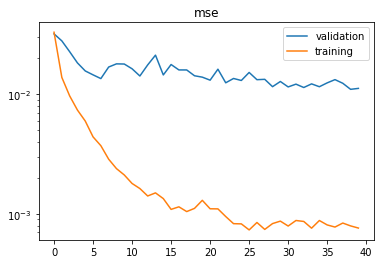

current model iteration =  2


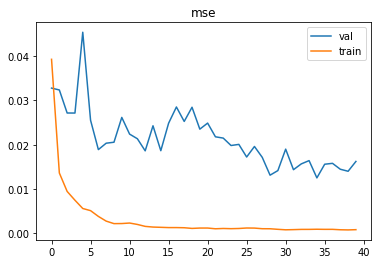

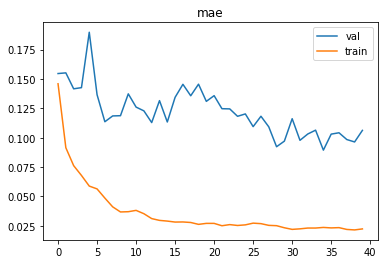

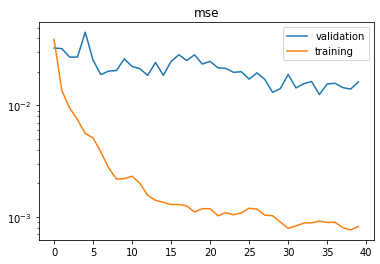

current model iteration =  3


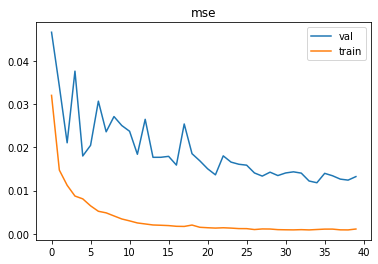

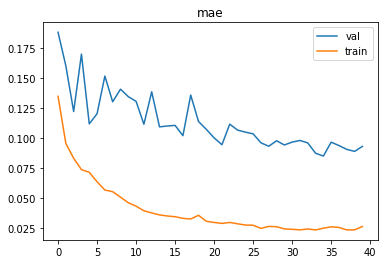

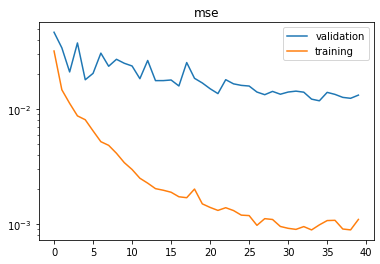

current model iteration =  4


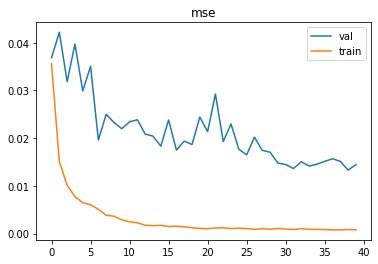

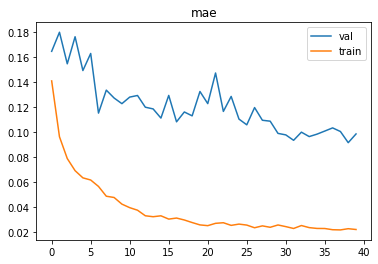

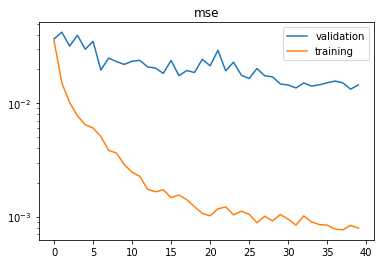

current model iteration =  5


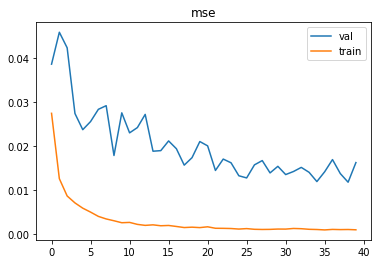

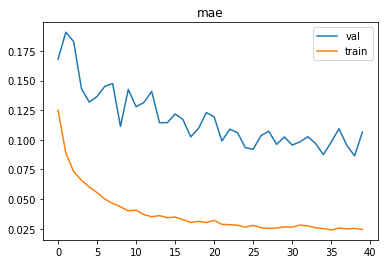

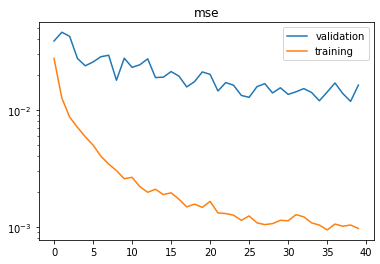

current model iteration =  6


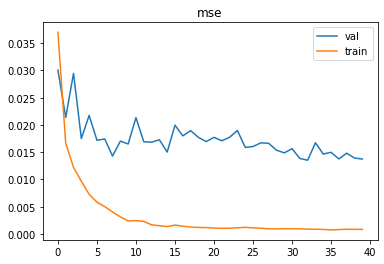

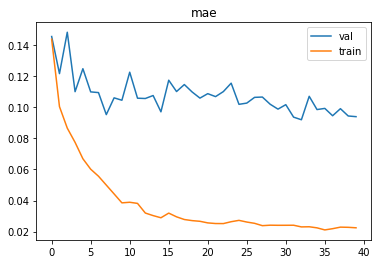

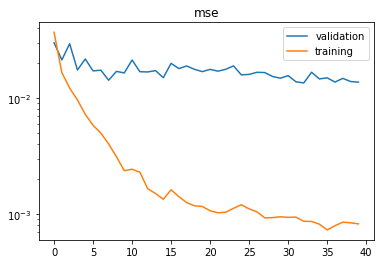

current model iteration =  7


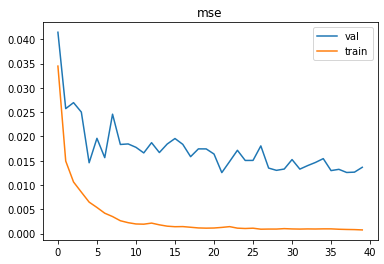

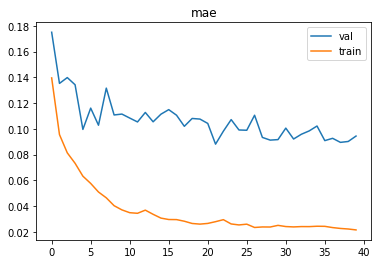

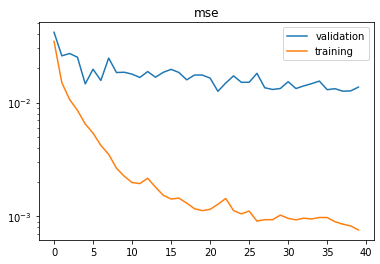

current model iteration =  8


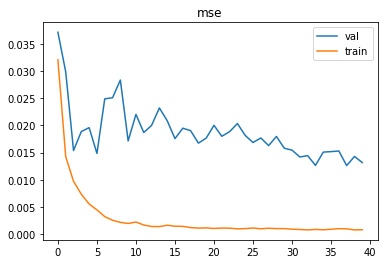

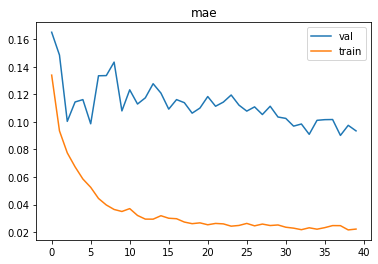

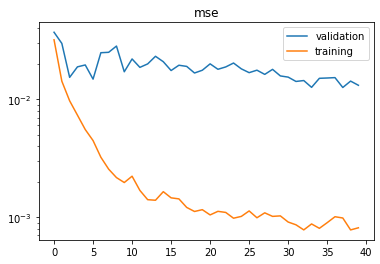

current model iteration =  9


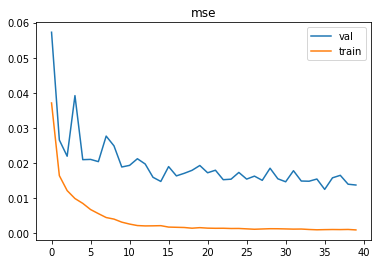

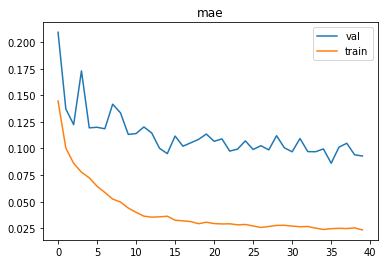

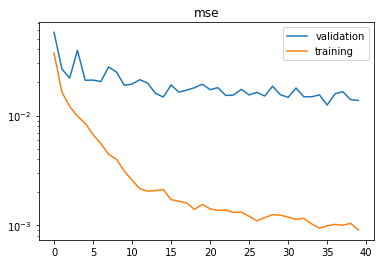

current model iteration =  10


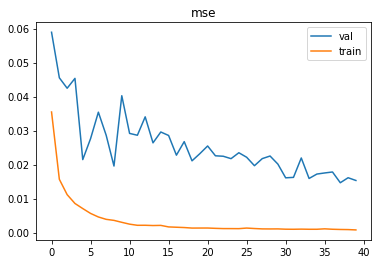

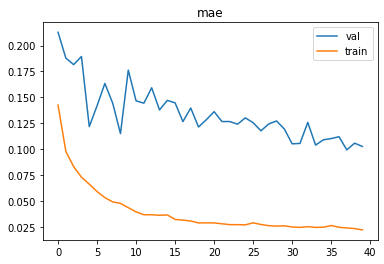

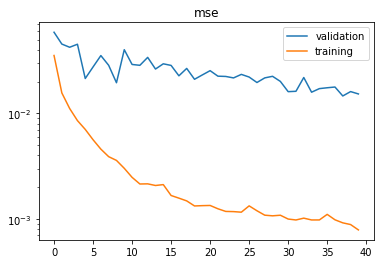

current model iteration =  11


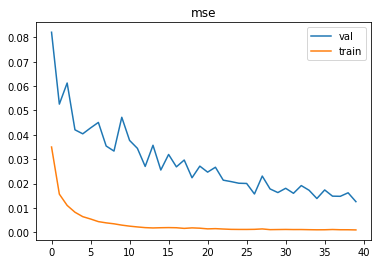

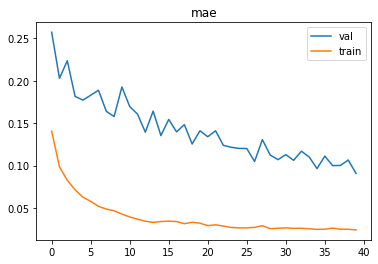

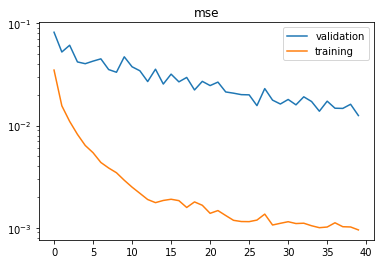

current model iteration =  12


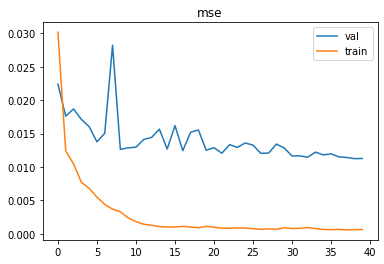

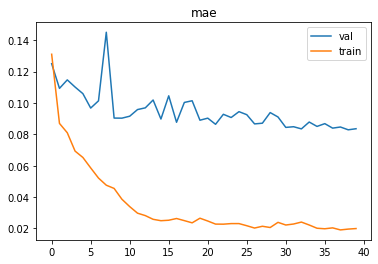

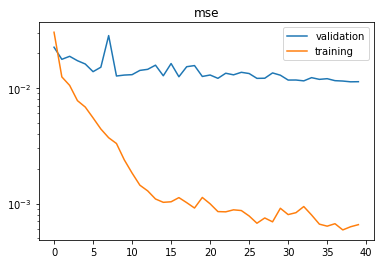

current model iteration =  13


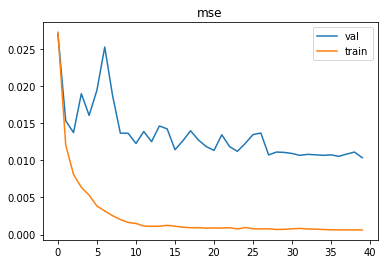

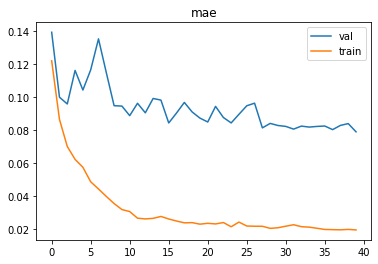

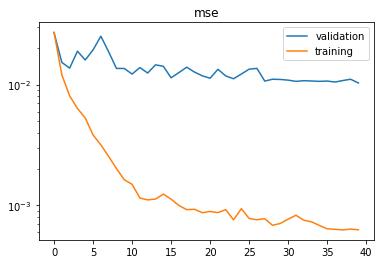

current model iteration =  14


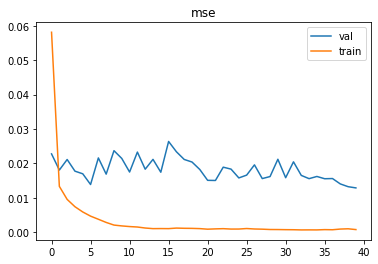

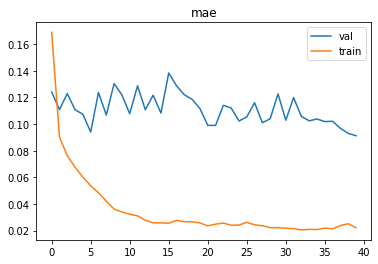

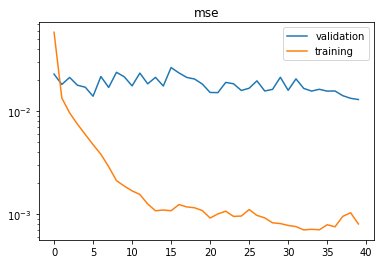

current model iteration =  15


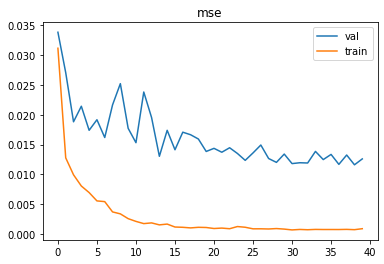

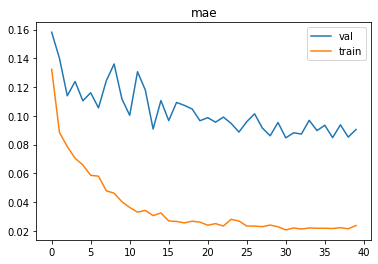

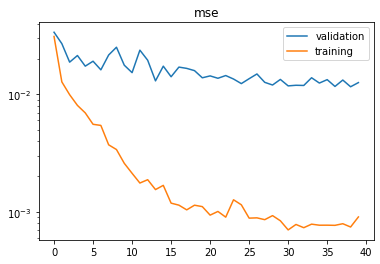

current model iteration =  16


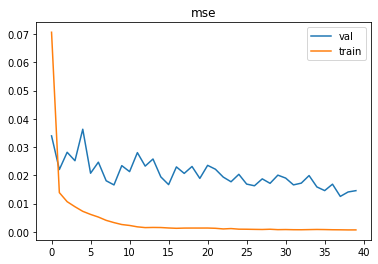

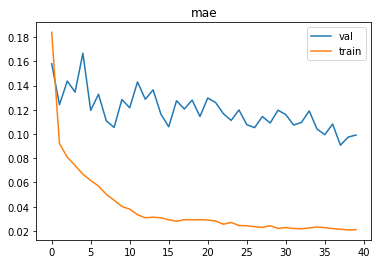

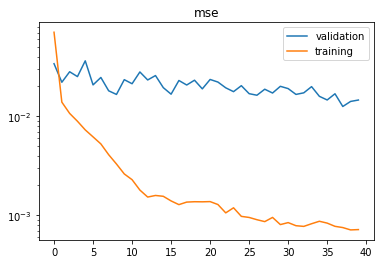

current model iteration =  17


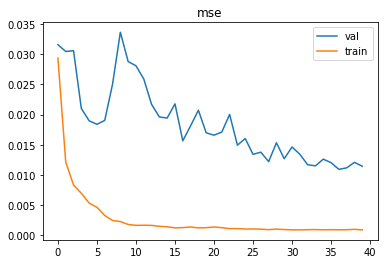

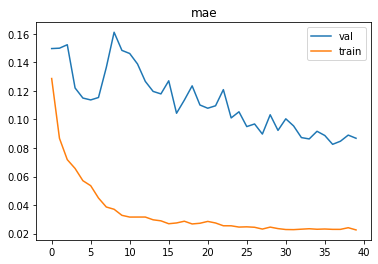

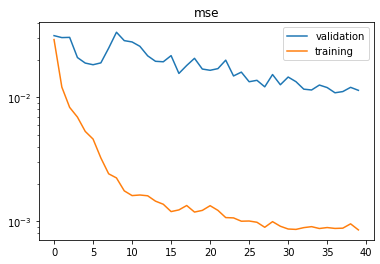

current model iteration =  18


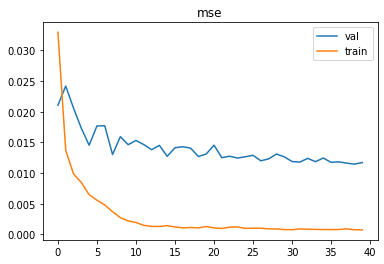

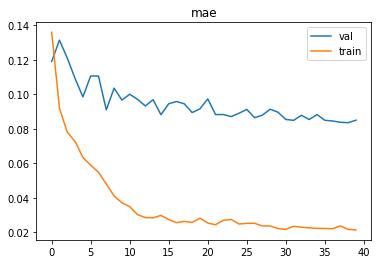

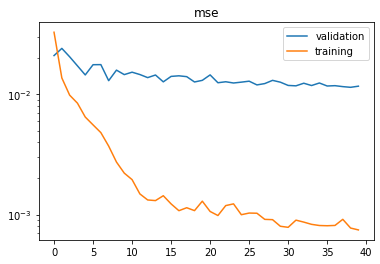

current model iteration =  19


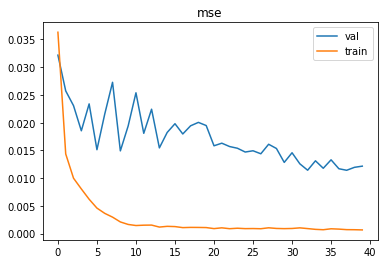

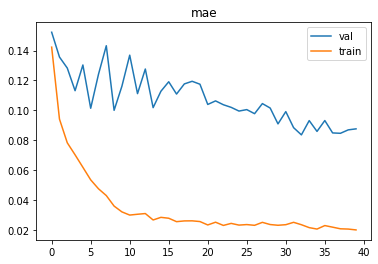

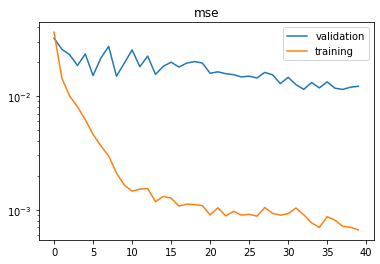

current model iteration =  20


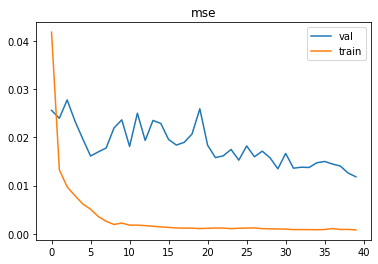

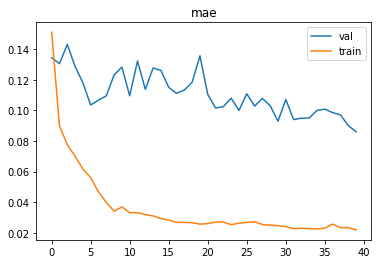

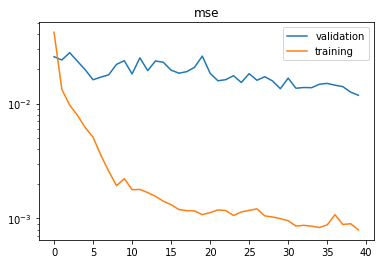

current model iteration =  21


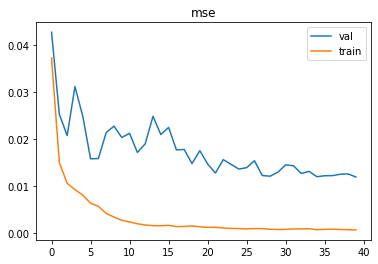

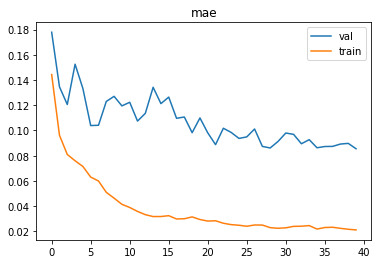

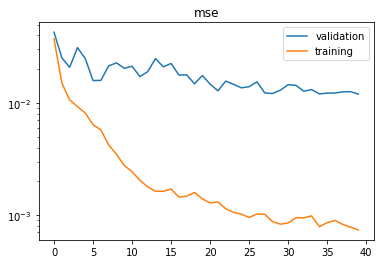

current model iteration =  22


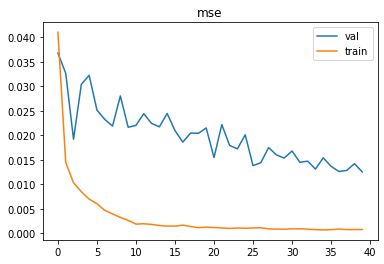

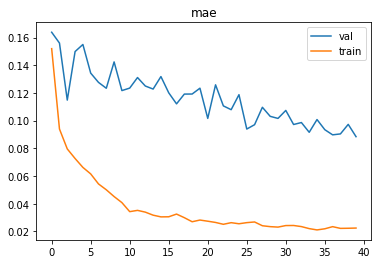

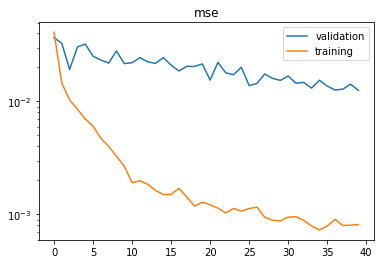

current model iteration =  23


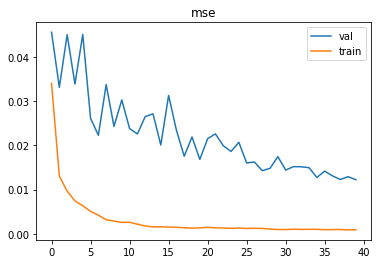

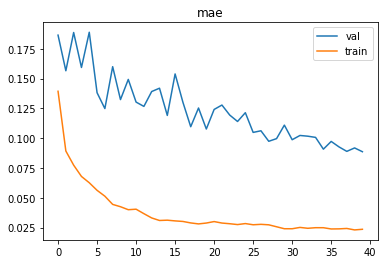

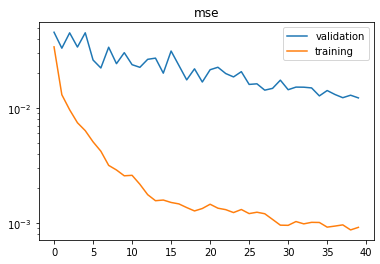

current model iteration =  24


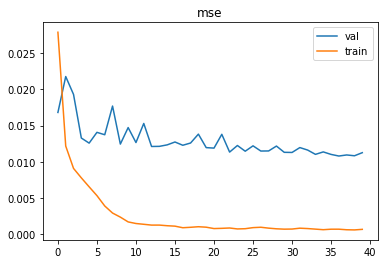

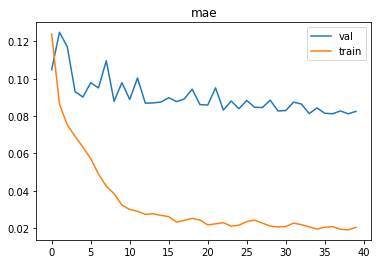

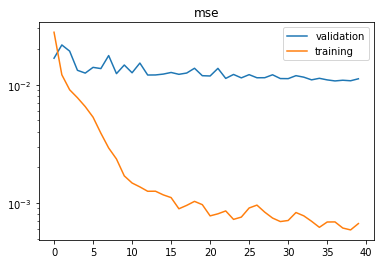

current model iteration =  25


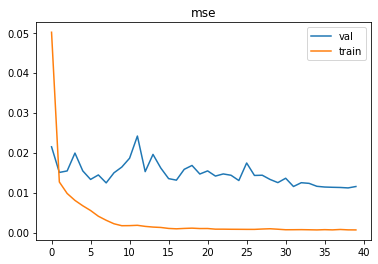

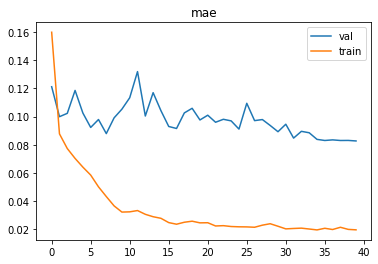

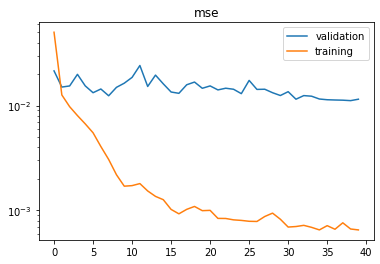

current model iteration =  26


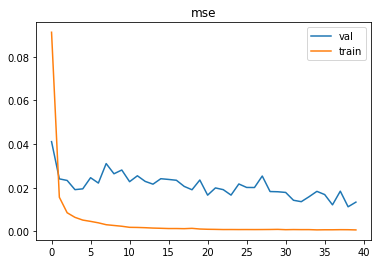

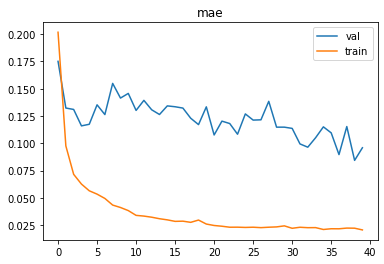

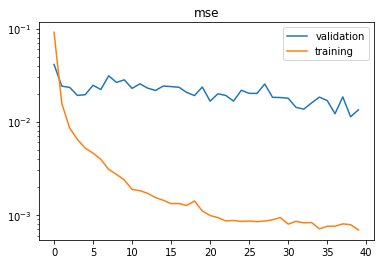

current model iteration =  27


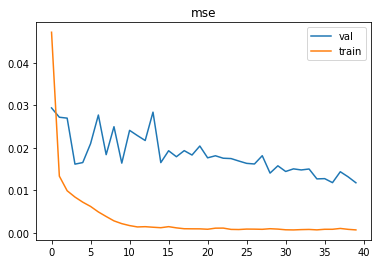

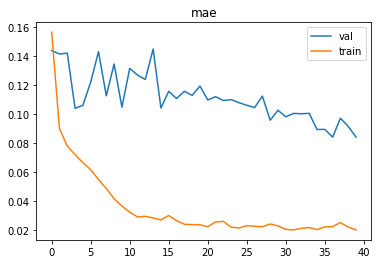

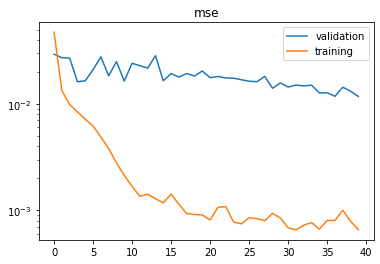

current model iteration =  28


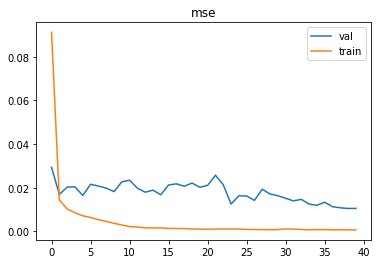

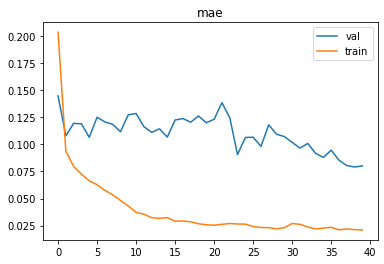

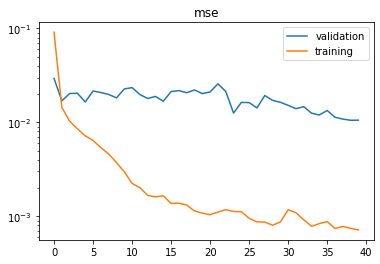

current model iteration =  29


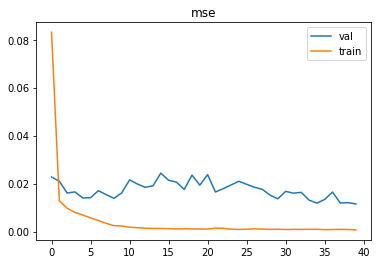

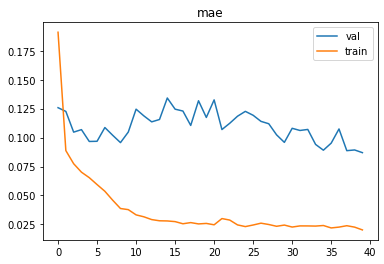

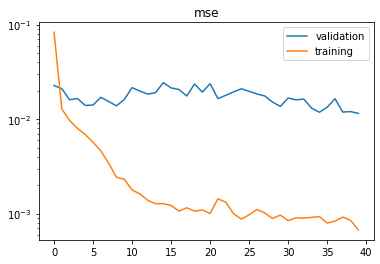

current model iteration =  30


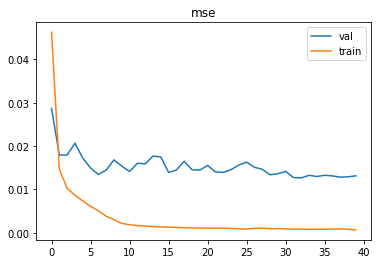

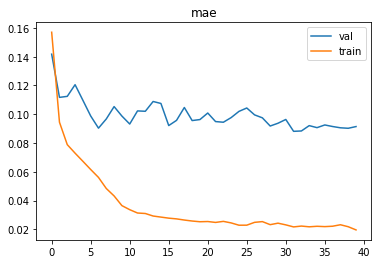

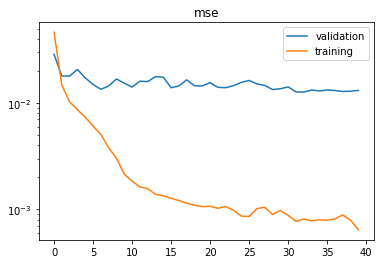

current model iteration =  31


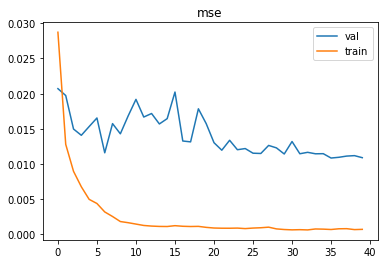

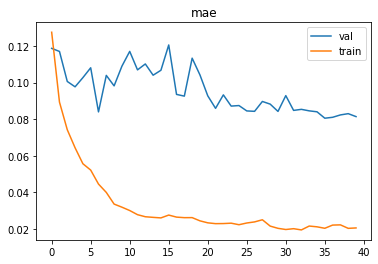

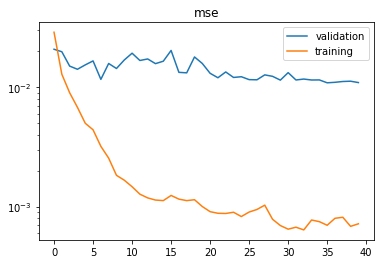

current model iteration =  32


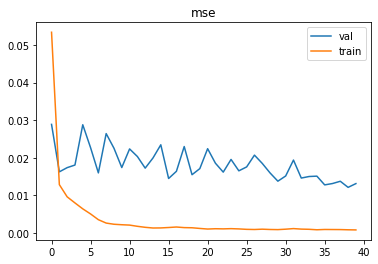

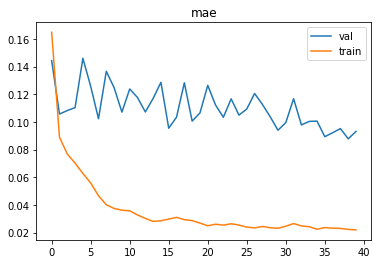

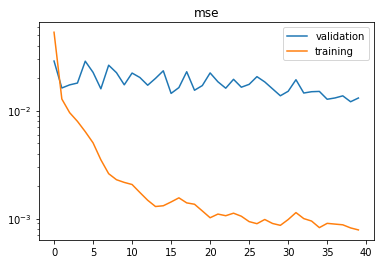

current model iteration =  33


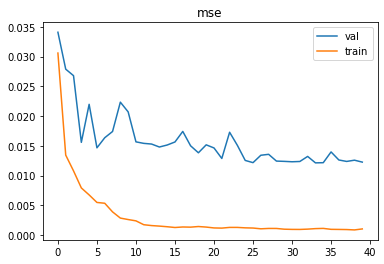

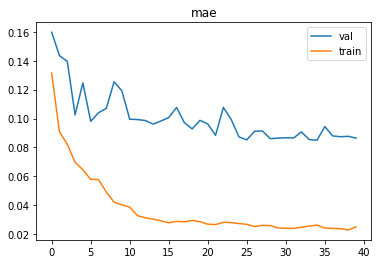

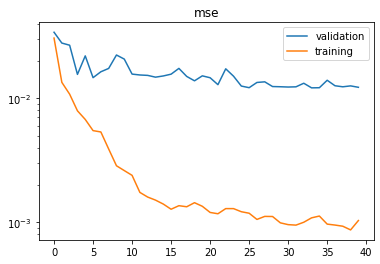

current model iteration =  34


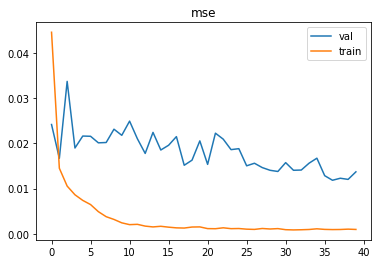

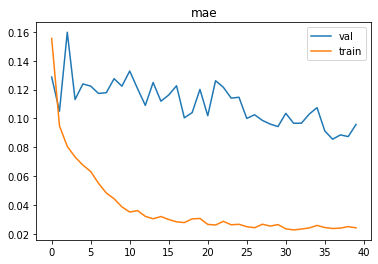

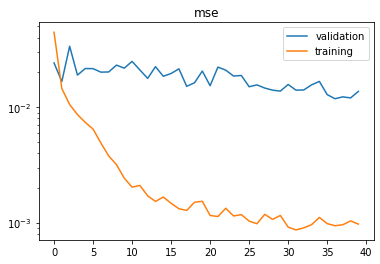

current model iteration =  35


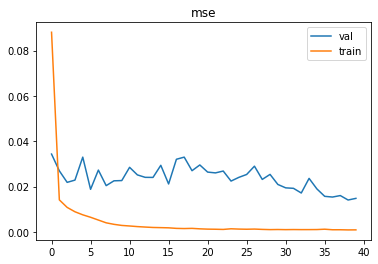

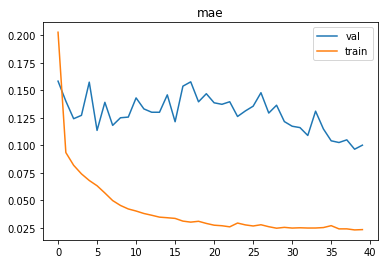

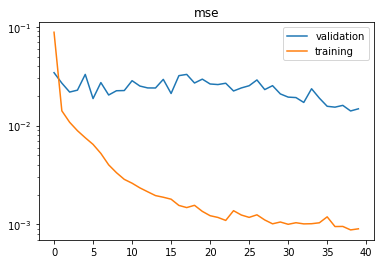

current model iteration =  36


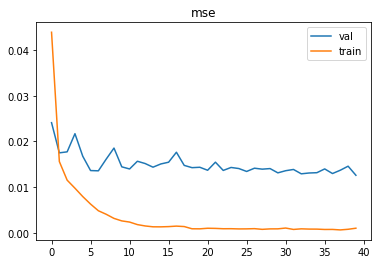

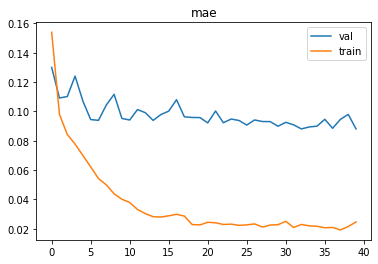

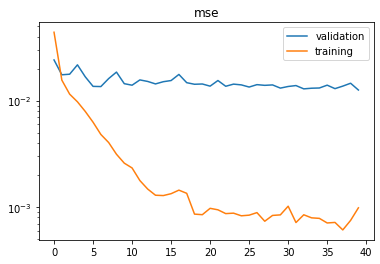

current model iteration =  37


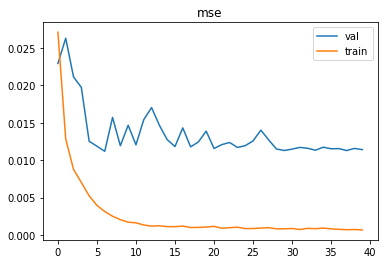

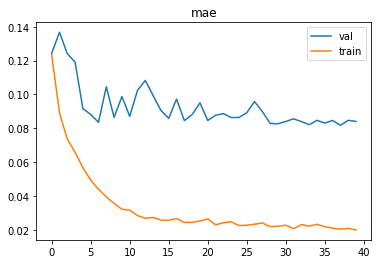

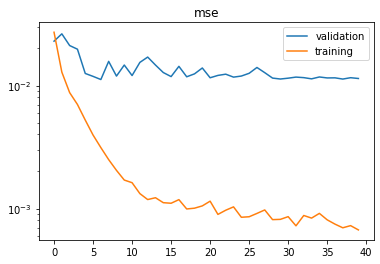

current model iteration =  38


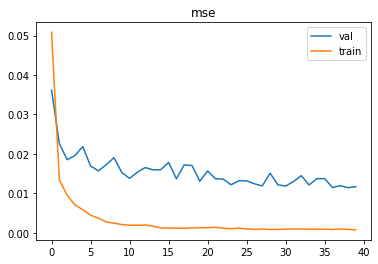

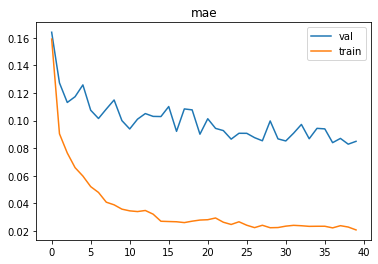

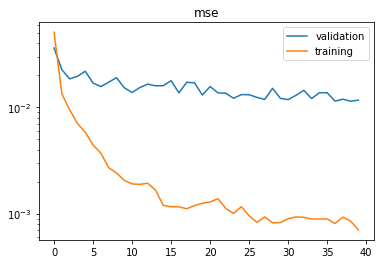

current model iteration =  39


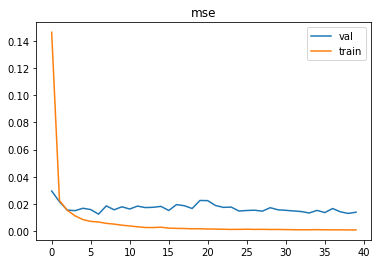

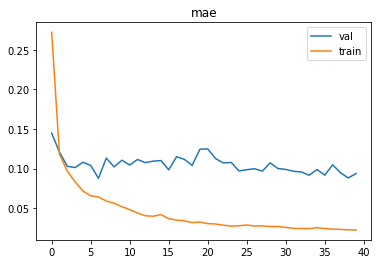

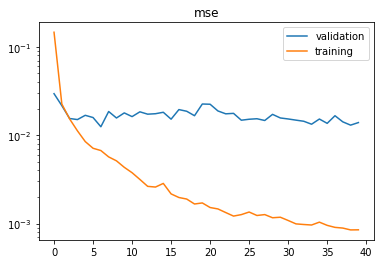

current model iteration =  40


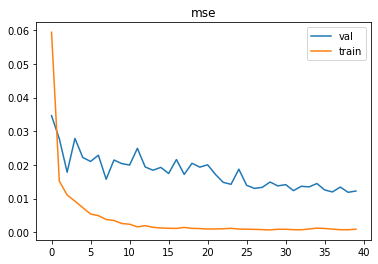

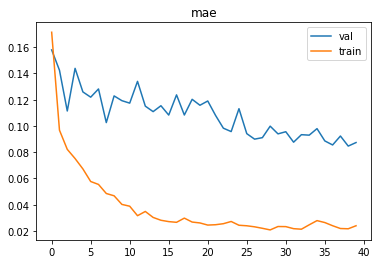

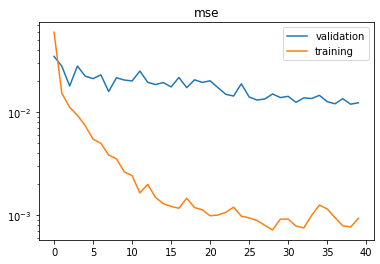

current model iteration =  41


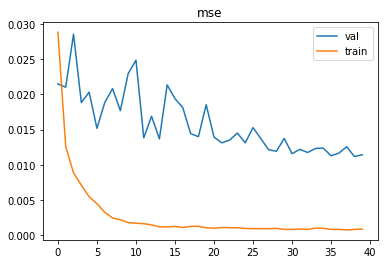

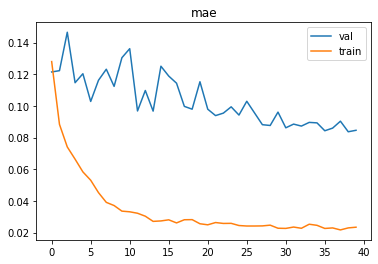

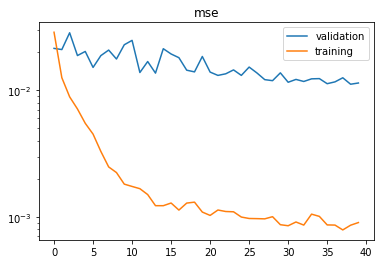

current model iteration =  42


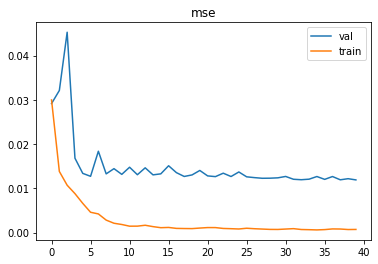

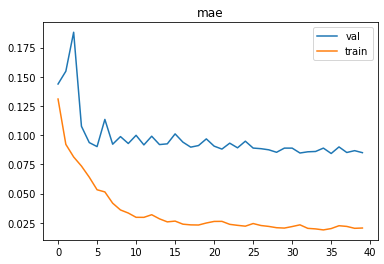

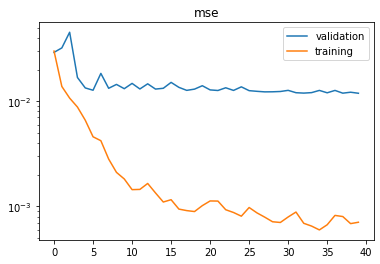

current model iteration =  43


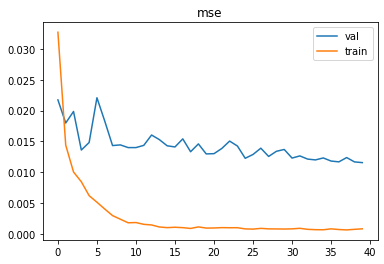

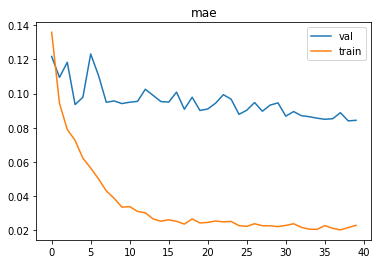

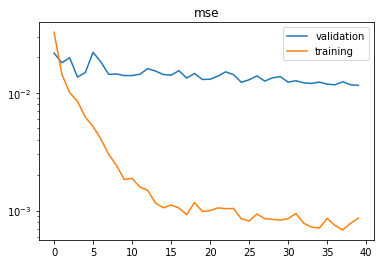

current model iteration =  44


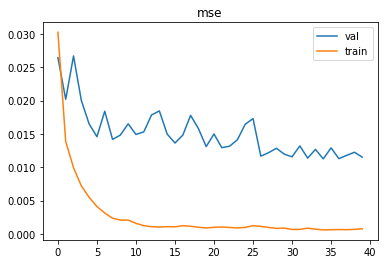

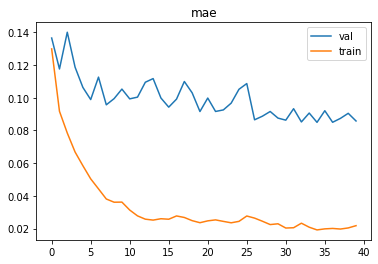

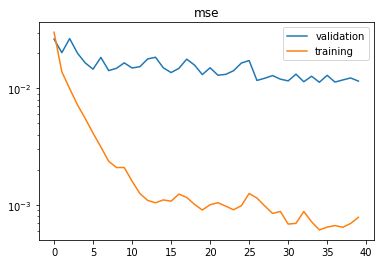

current model iteration =  45


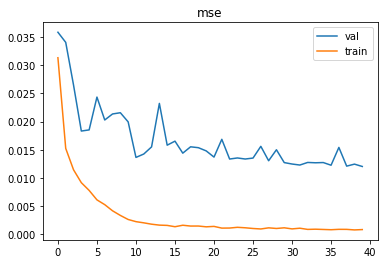

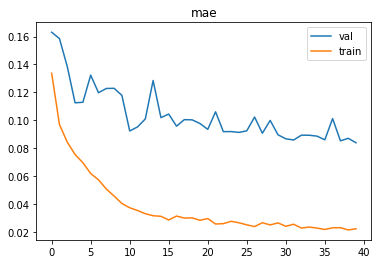

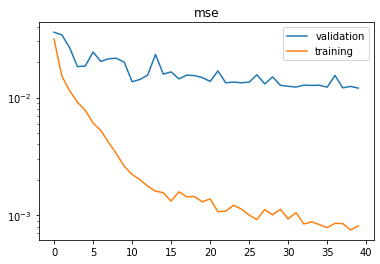

current model iteration =  46


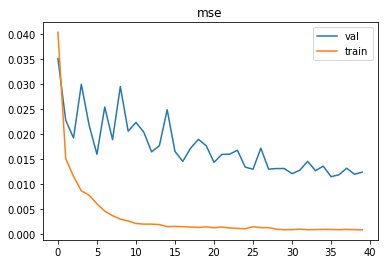

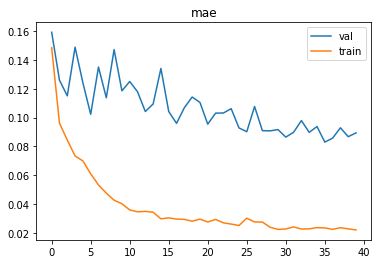

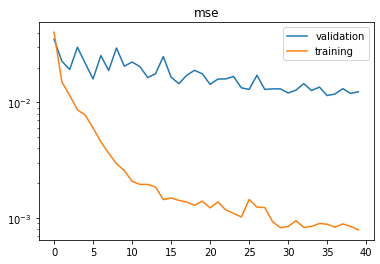

current model iteration =  47


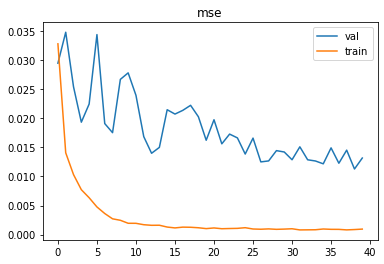

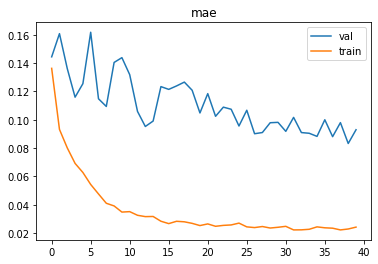

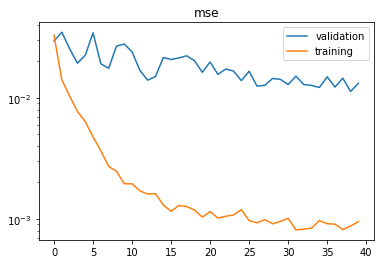

current model iteration =  48


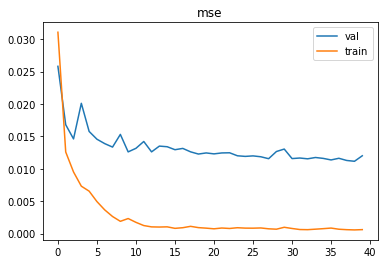

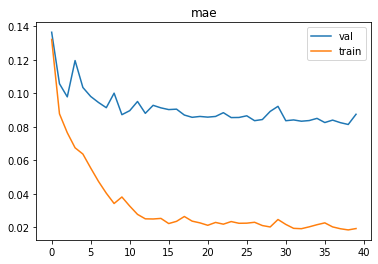

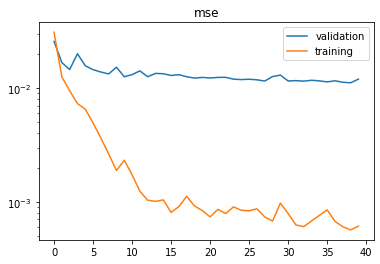

current model iteration =  49


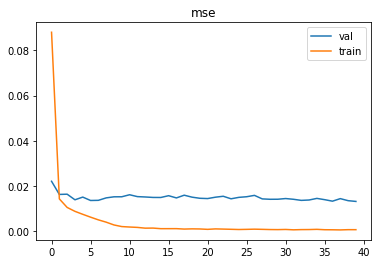

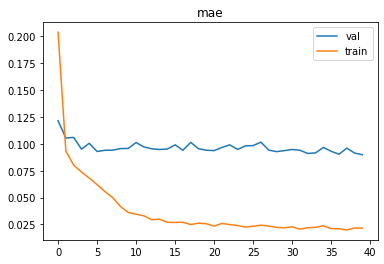

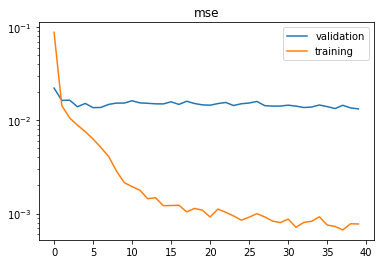

current model iteration =  50


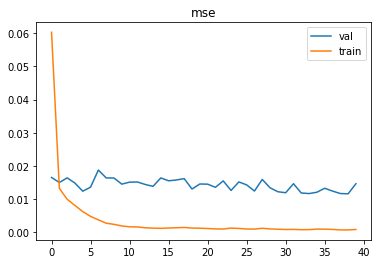

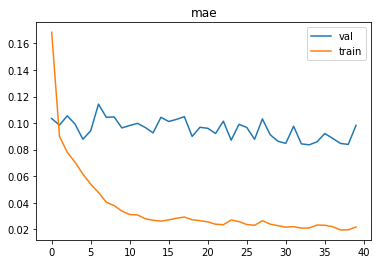

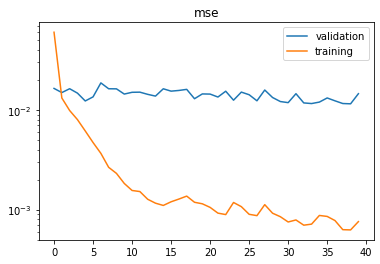

current model iteration =  51


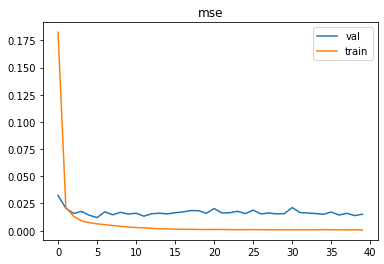

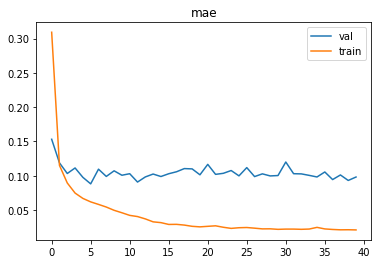

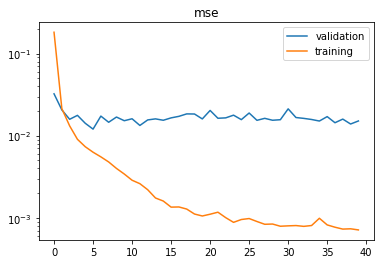

current model iteration =  52


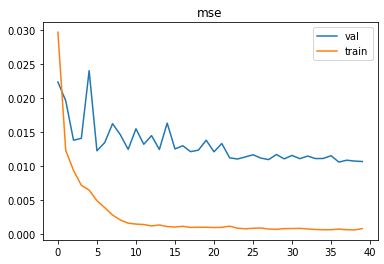

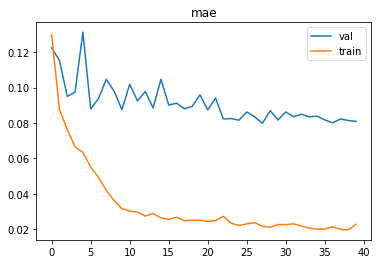

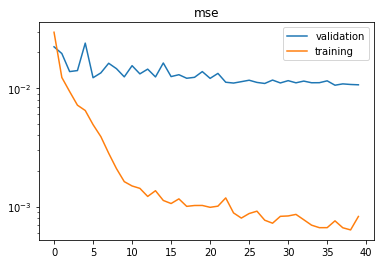

current model iteration =  53


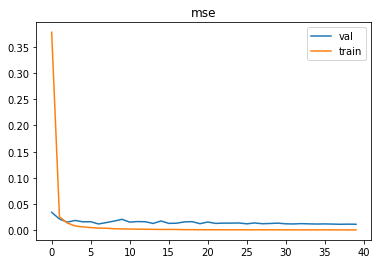

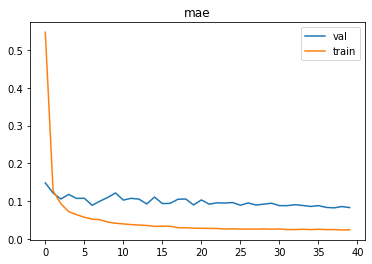

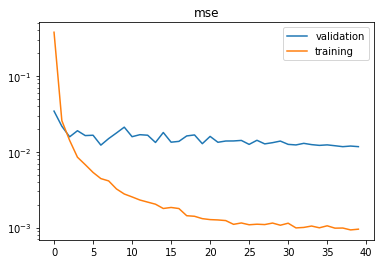

current model iteration =  54


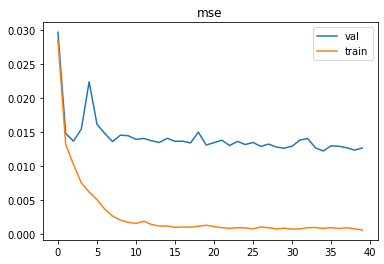

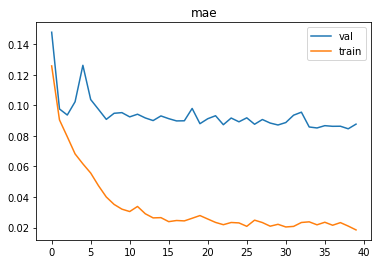

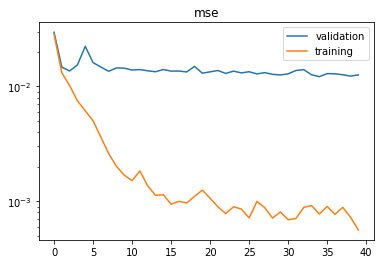

current model iteration =  55


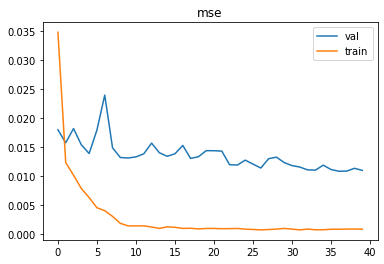

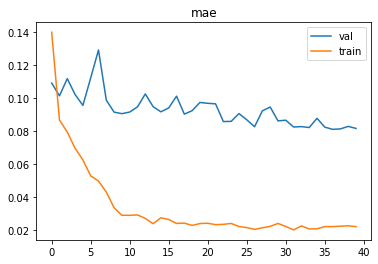

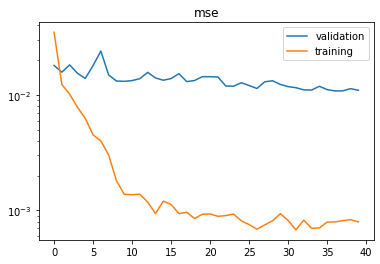

current model iteration =  56


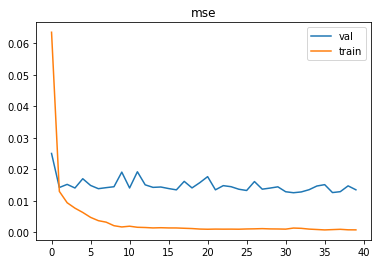

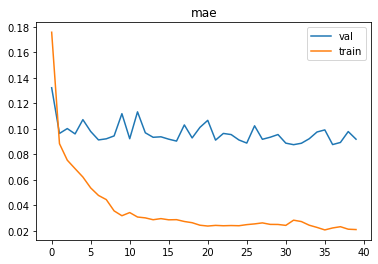

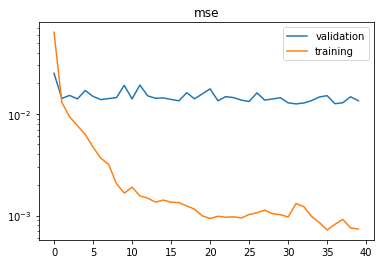

current model iteration =  57


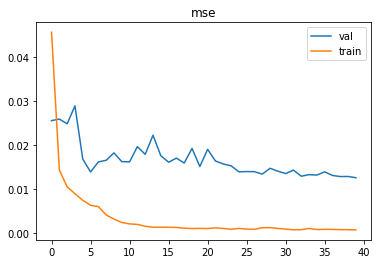

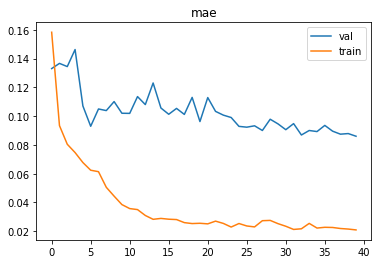

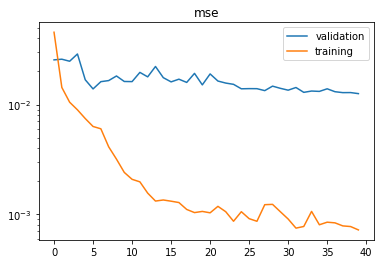

current model iteration =  58


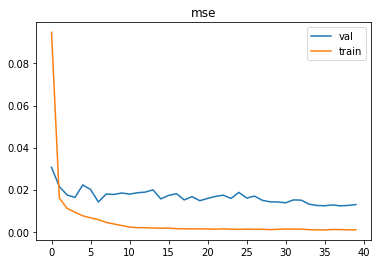

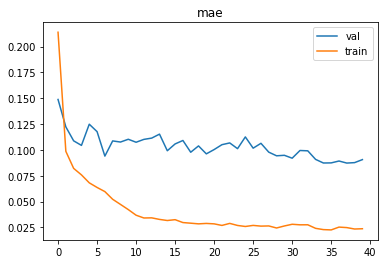

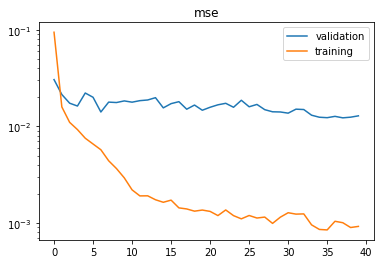

current model iteration =  59


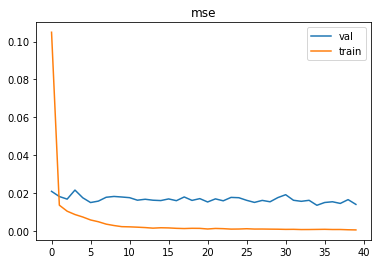

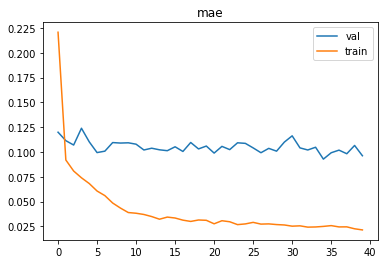

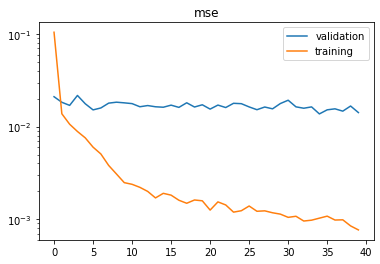

current model iteration =  60


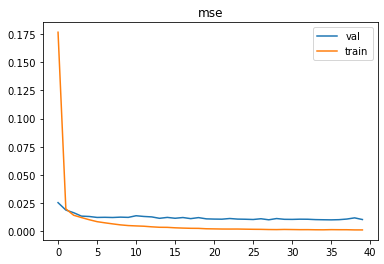

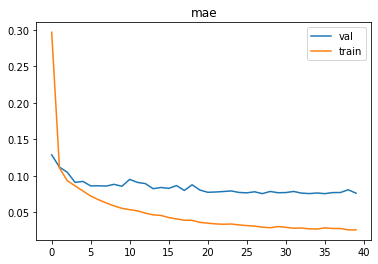

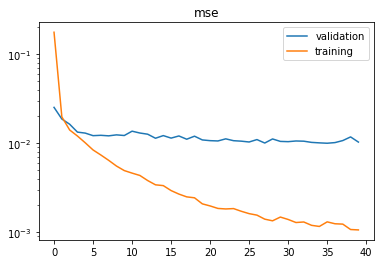

current model iteration =  61


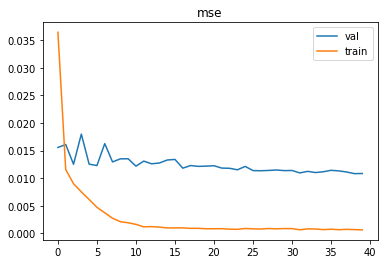

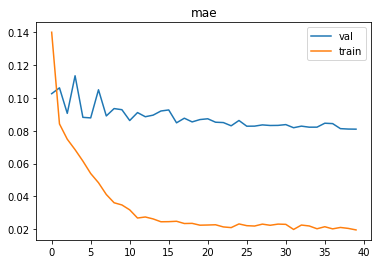

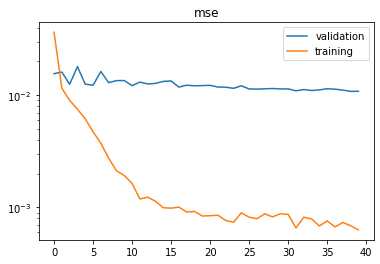

current model iteration =  62


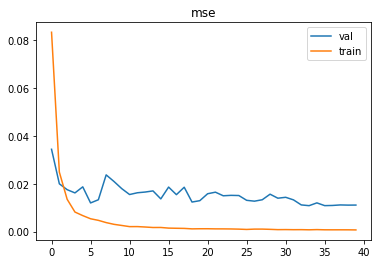

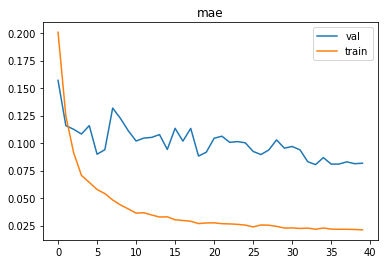

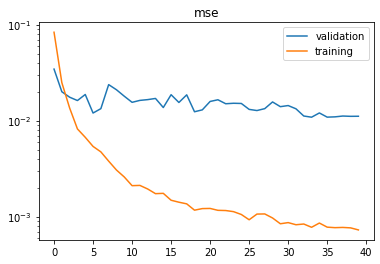

current model iteration =  63


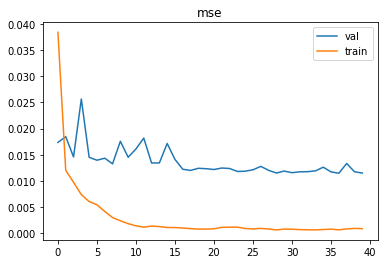

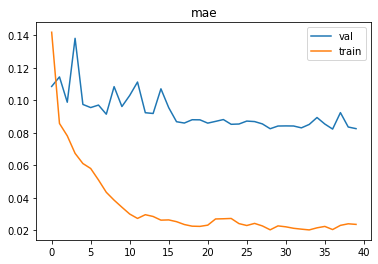

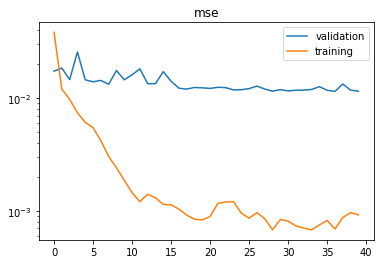

current model iteration =  64


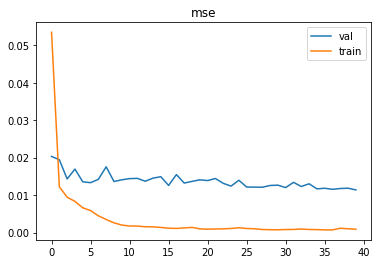

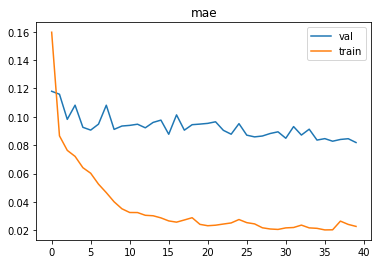

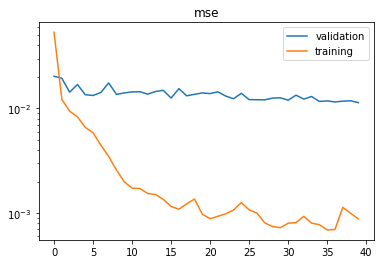

current model iteration =  65


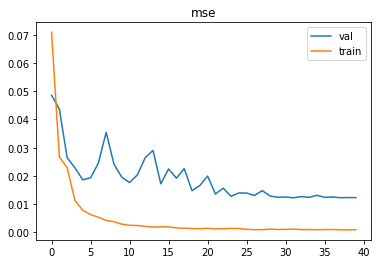

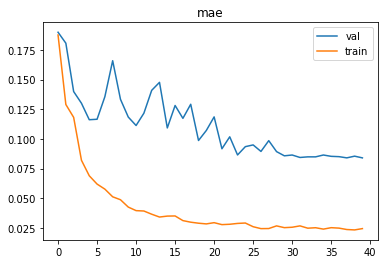

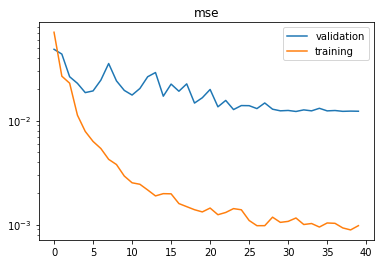

current model iteration =  66


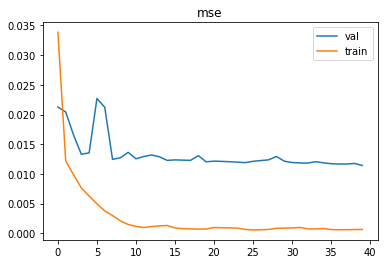

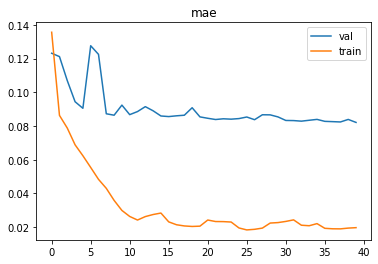

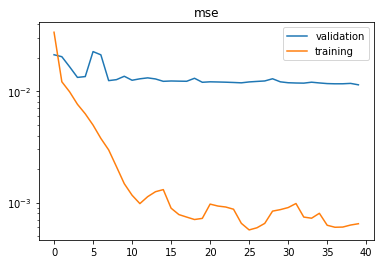

current model iteration =  67


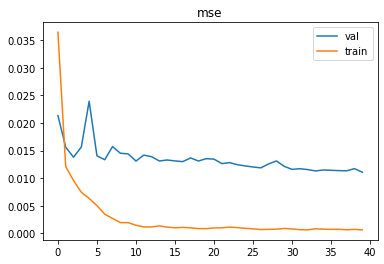

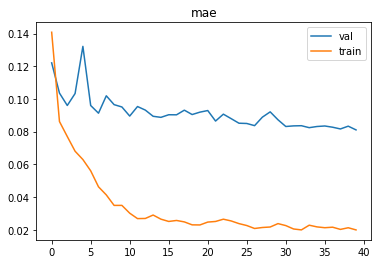

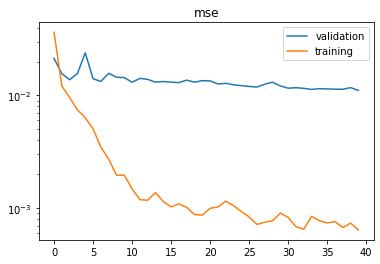

current model iteration =  68


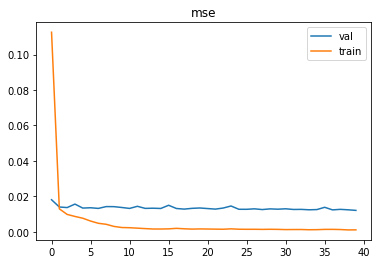

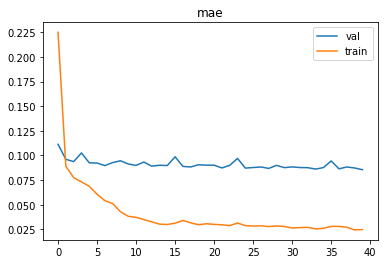

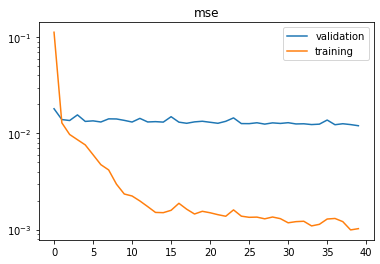

current model iteration =  69


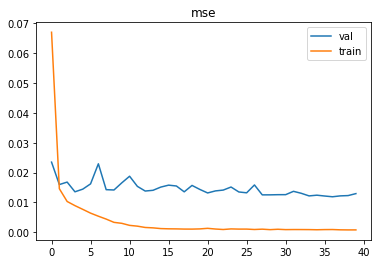

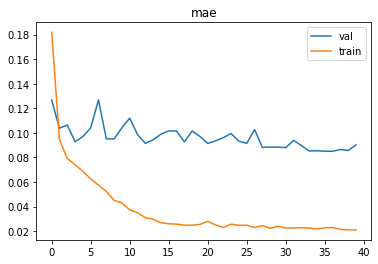

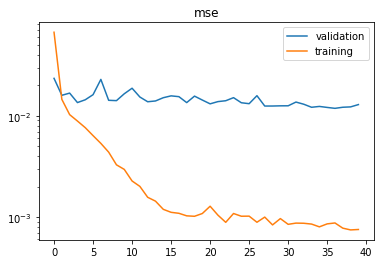

current model iteration =  70


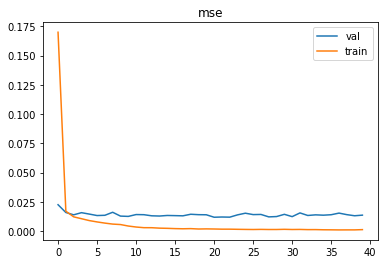

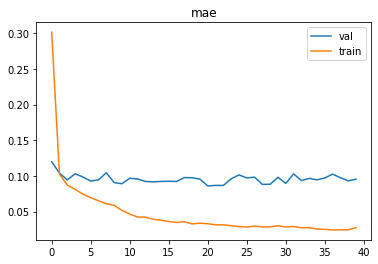

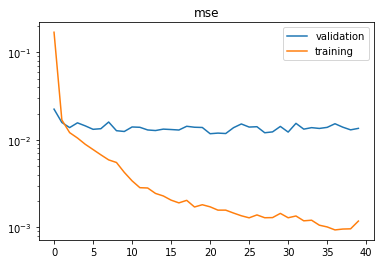

current model iteration =  71


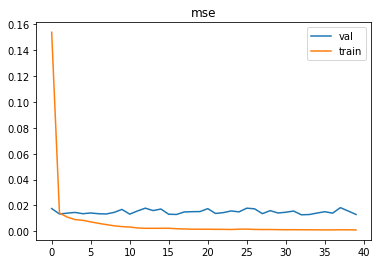

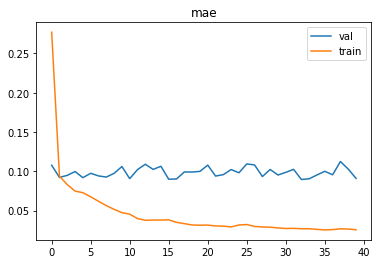

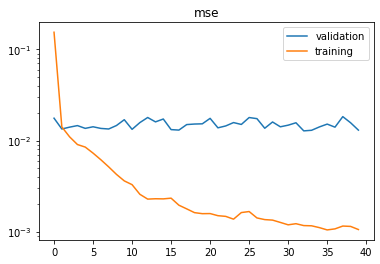

current model iteration =  72


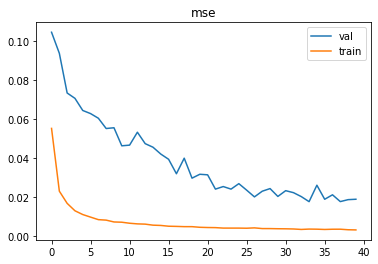

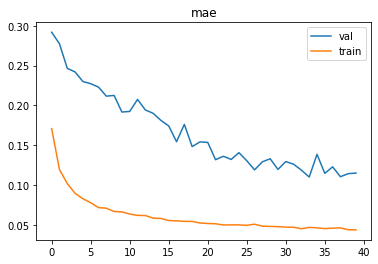

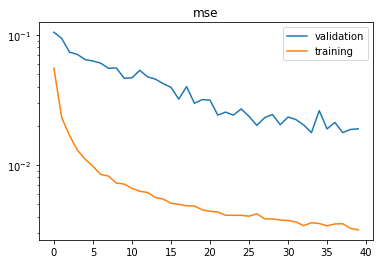

current model iteration =  73


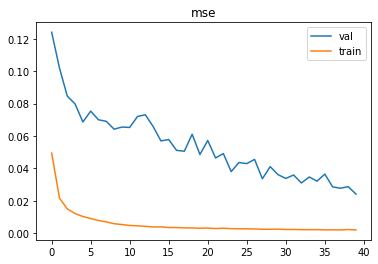

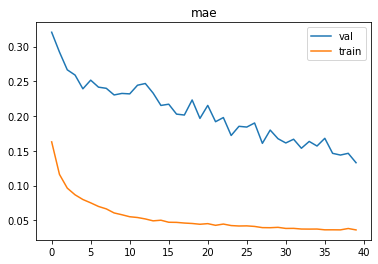

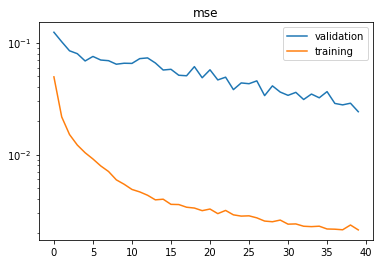

current model iteration =  74


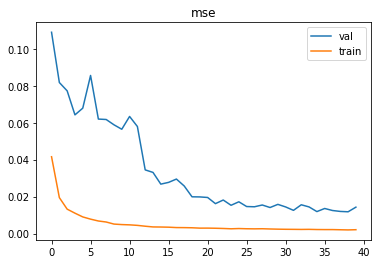

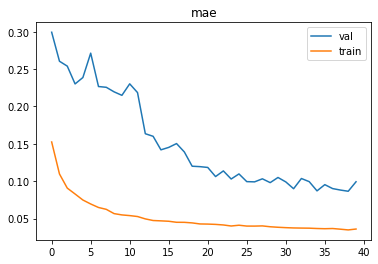

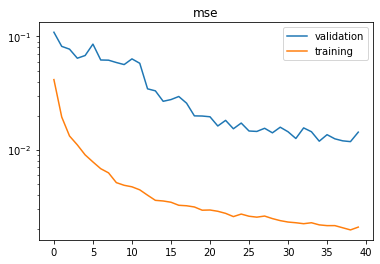

current model iteration =  75


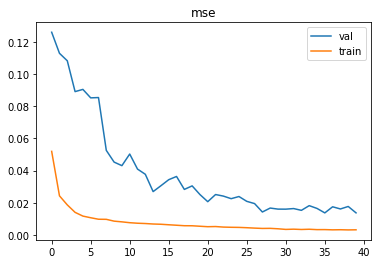

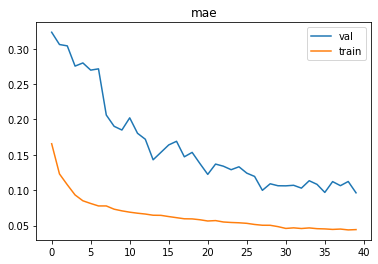

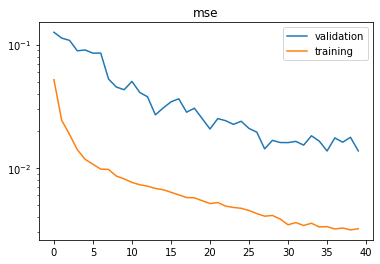

current model iteration =  76


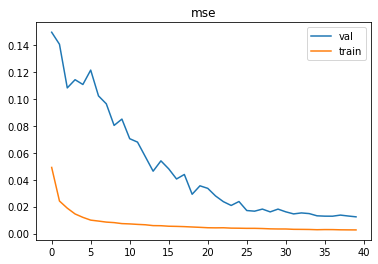

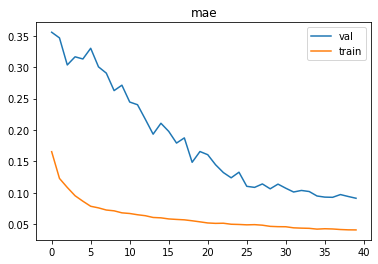

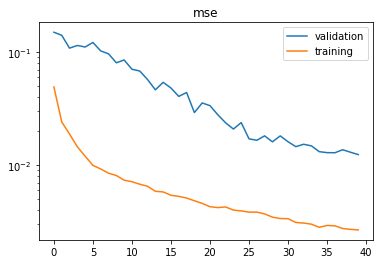

current model iteration =  77


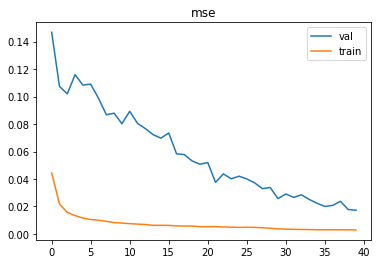

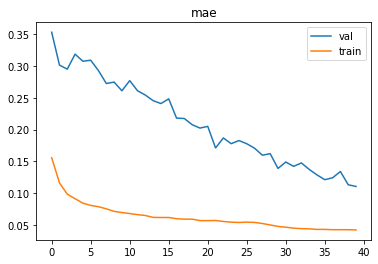

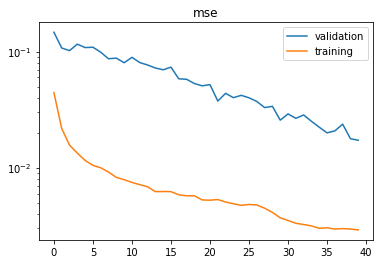

current model iteration =  78


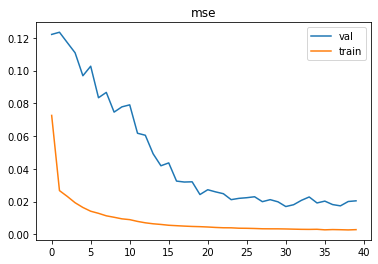

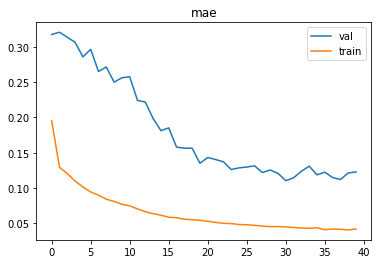

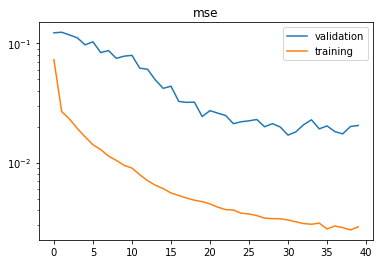

current model iteration =  79


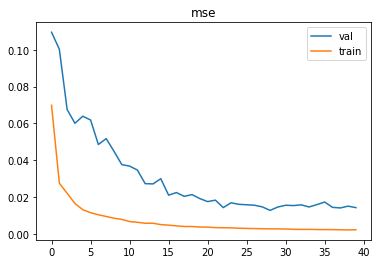

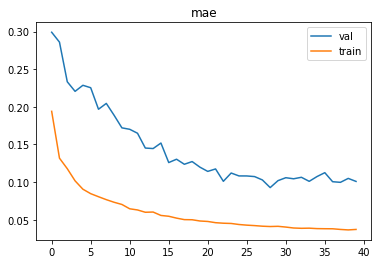

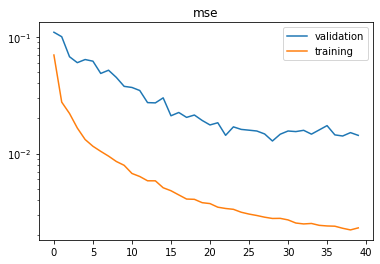

current model iteration =  80


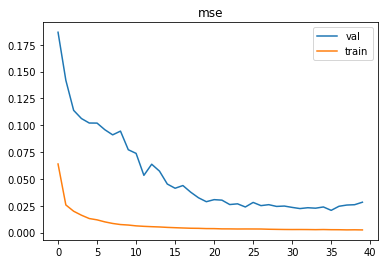

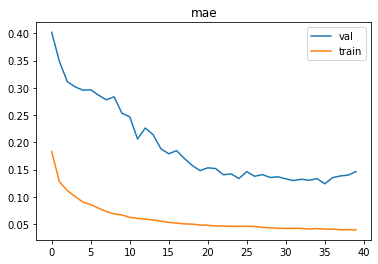

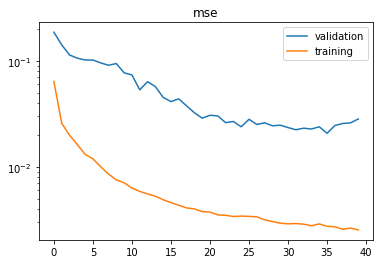

current model iteration =  81


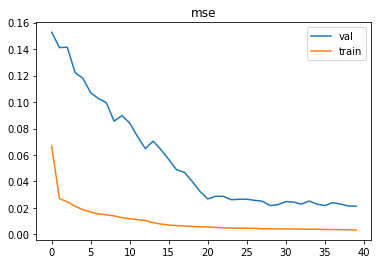

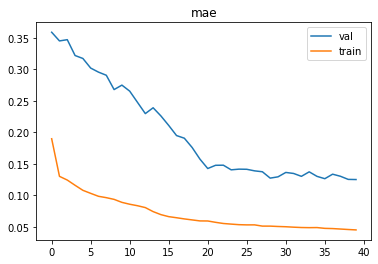

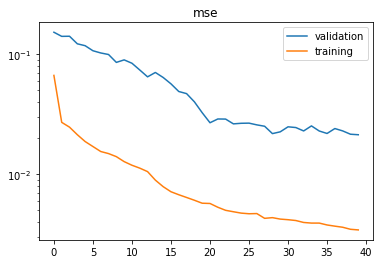

current model iteration =  82


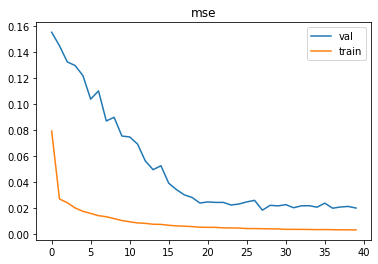

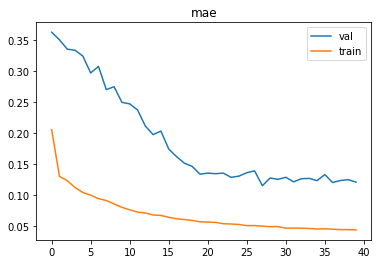

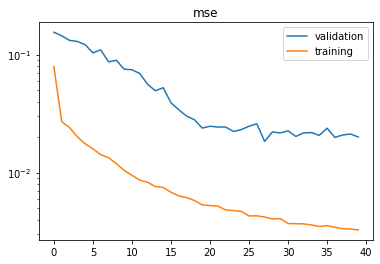

current model iteration =  83


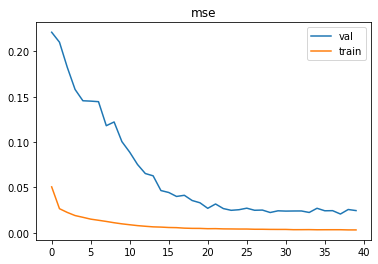

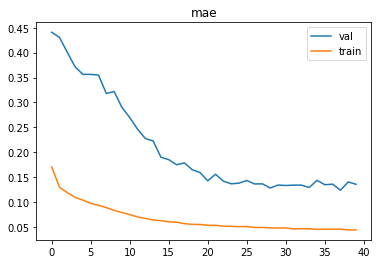

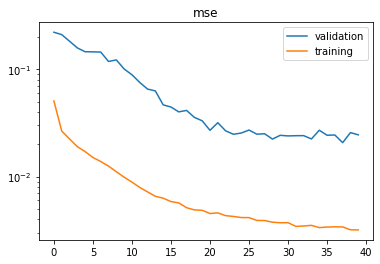

current model iteration =  84


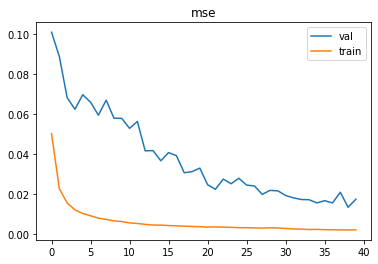

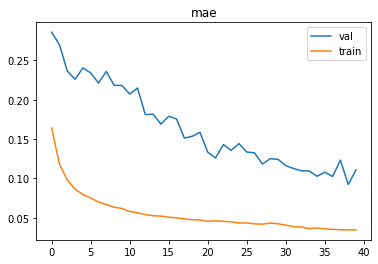

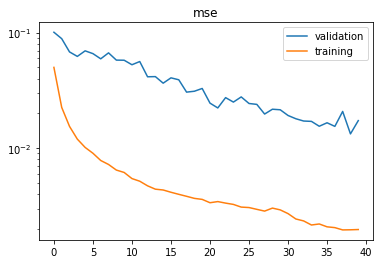

current model iteration =  85


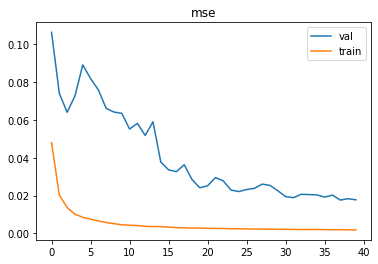

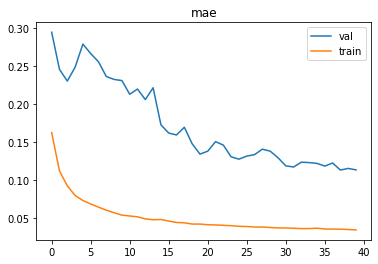

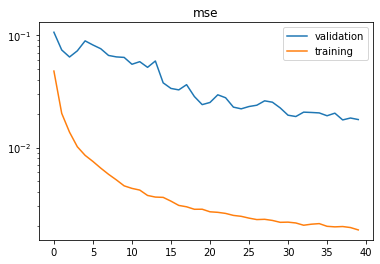

current model iteration =  86


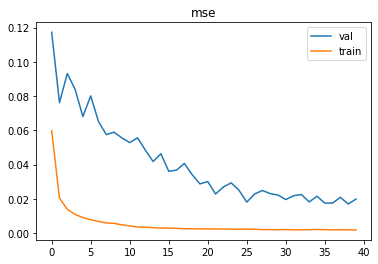

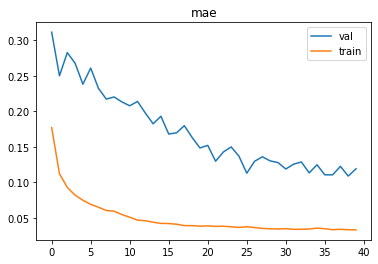

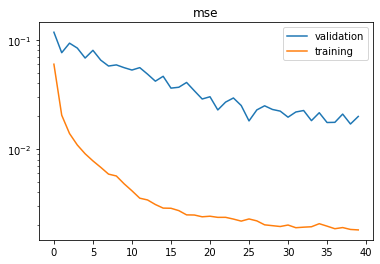

current model iteration =  87


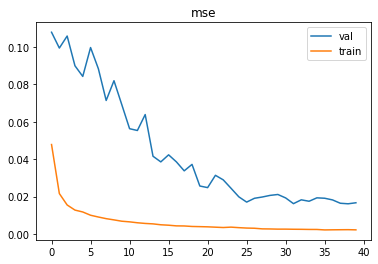

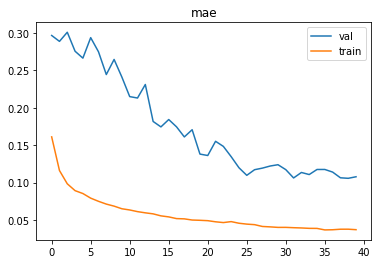

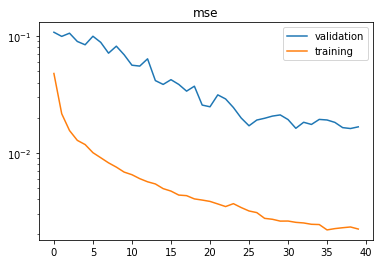

current model iteration =  88


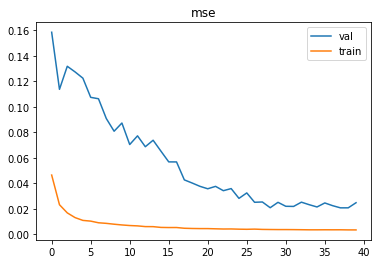

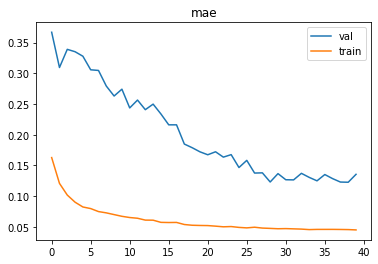

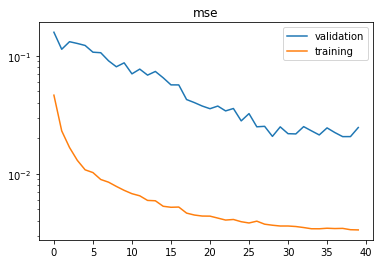

current model iteration =  89


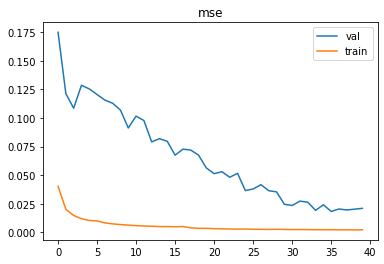

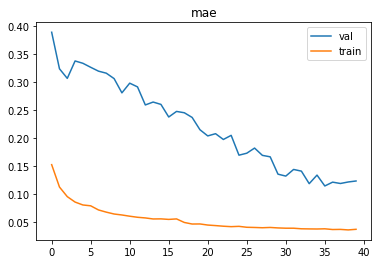

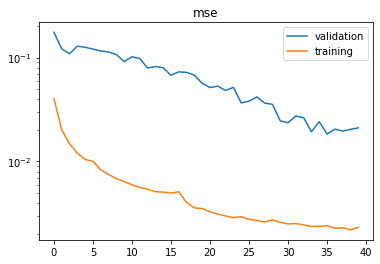

current model iteration =  90


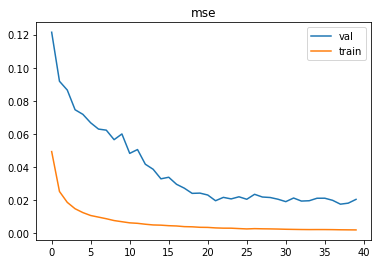

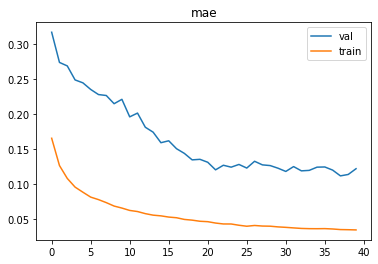

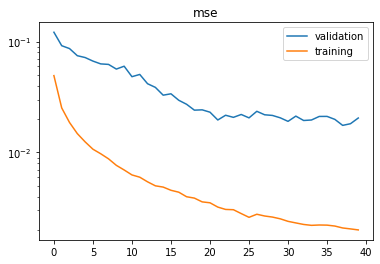

current model iteration =  91


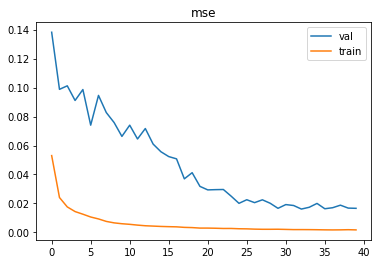

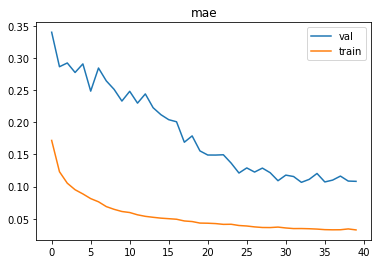

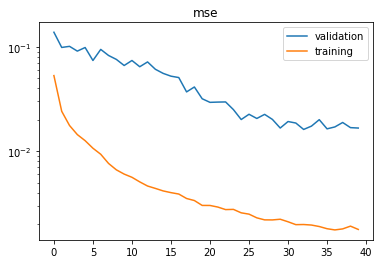

current model iteration =  92


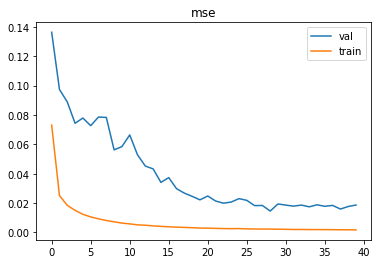

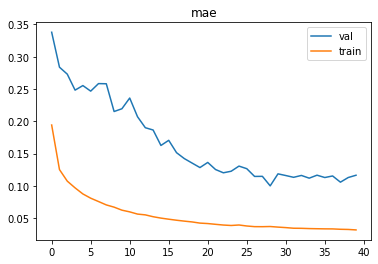

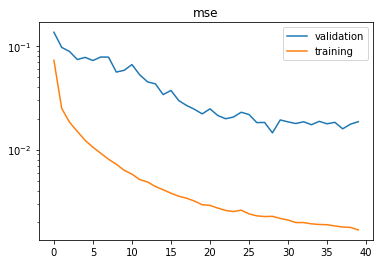

current model iteration =  93


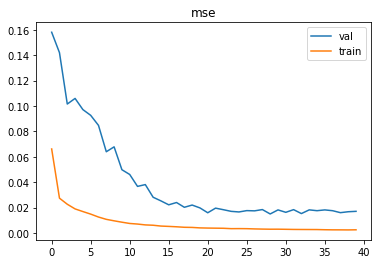

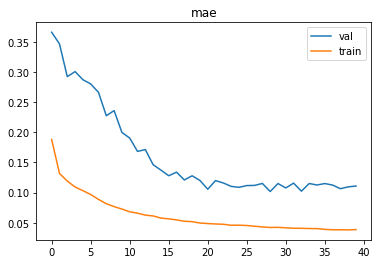

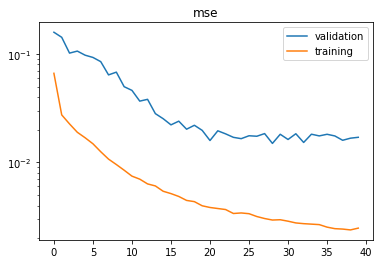

current model iteration =  94


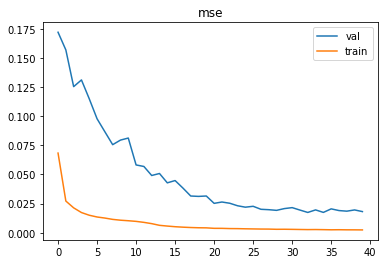

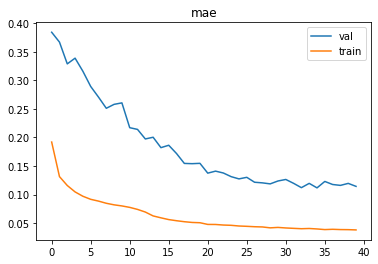

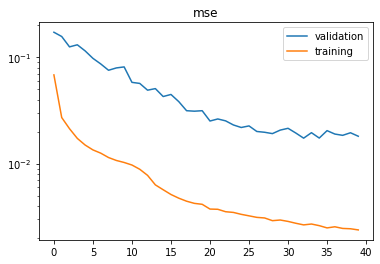

current model iteration =  95


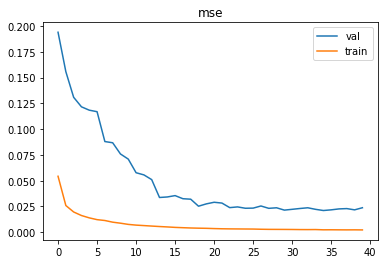

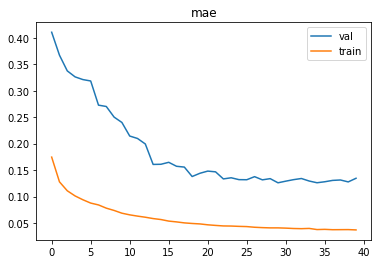

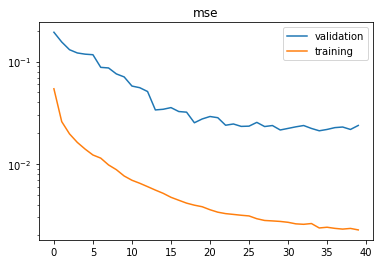

current model iteration =  96


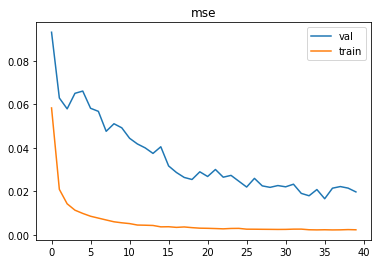

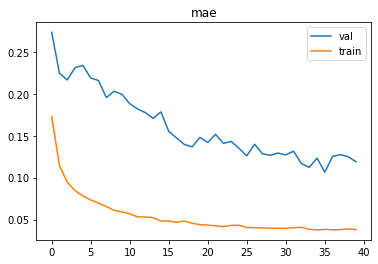

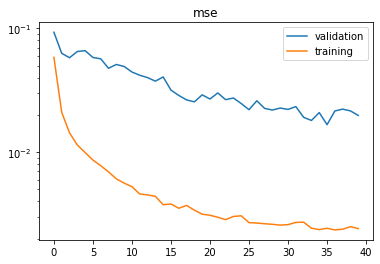

current model iteration =  97


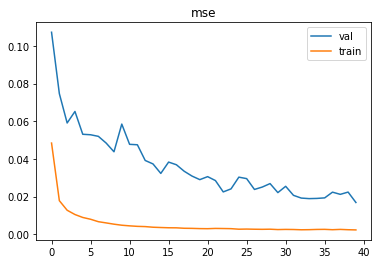

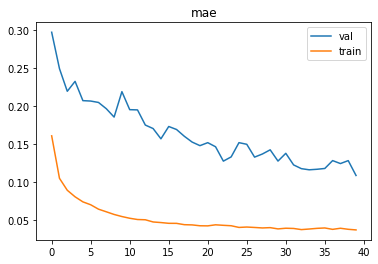

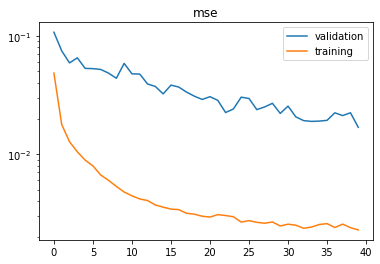

current model iteration =  98


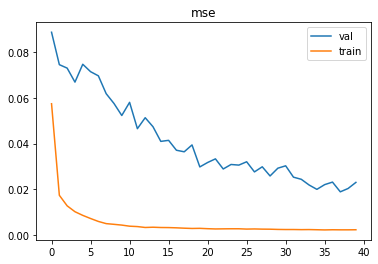

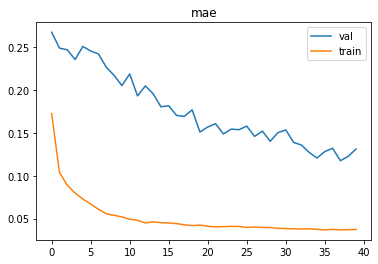

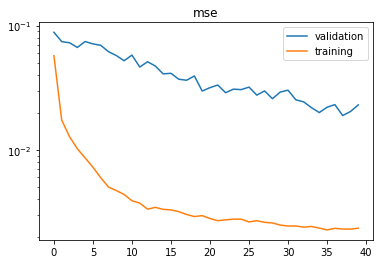

current model iteration =  99


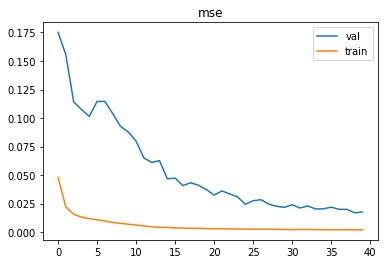

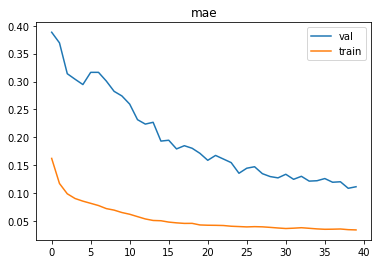

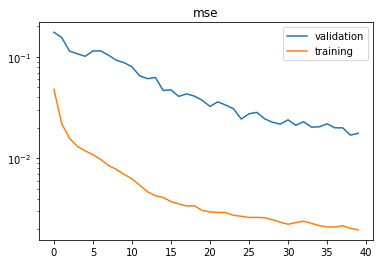

current model iteration =  100


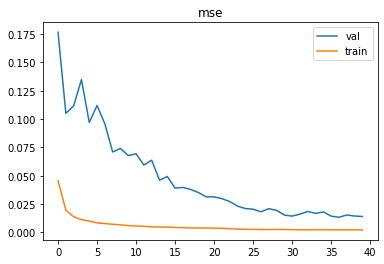

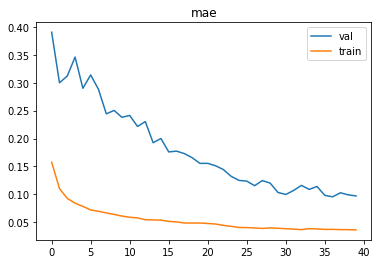

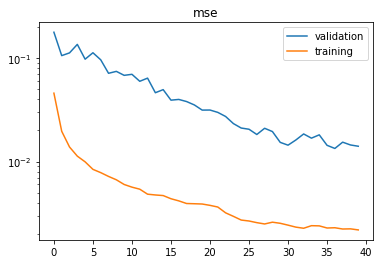

current model iteration =  101


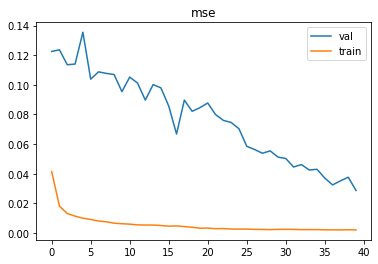

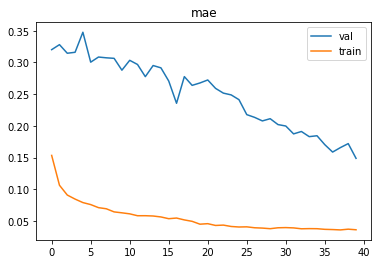

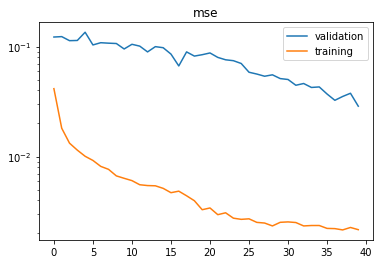

current model iteration =  102


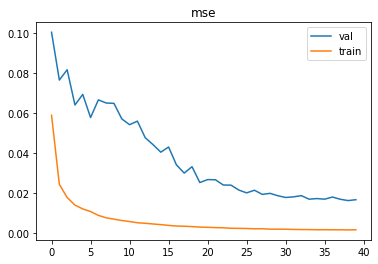

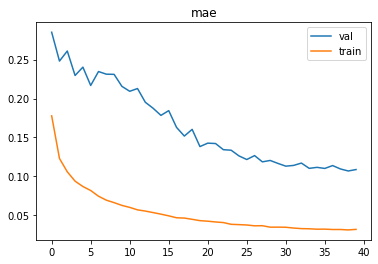

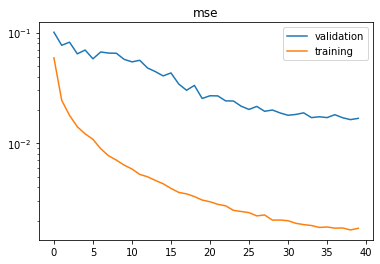

current model iteration =  103


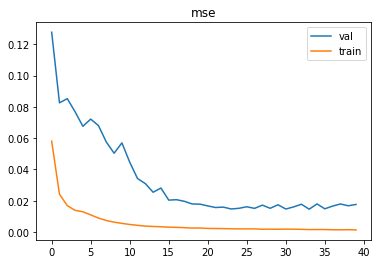

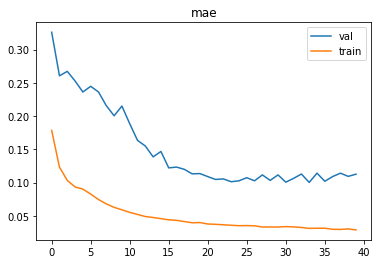

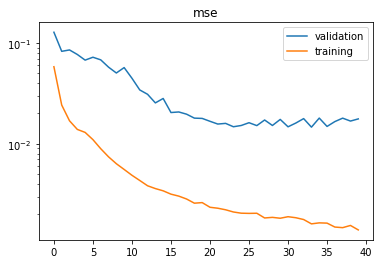

current model iteration =  104


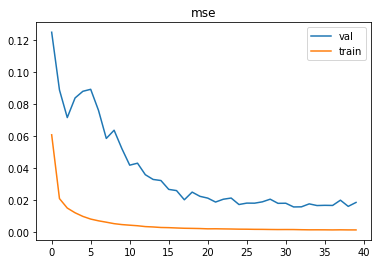

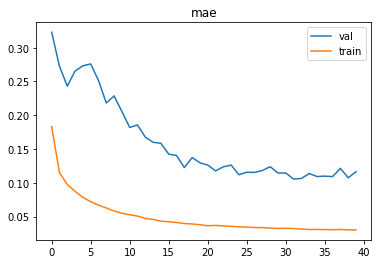

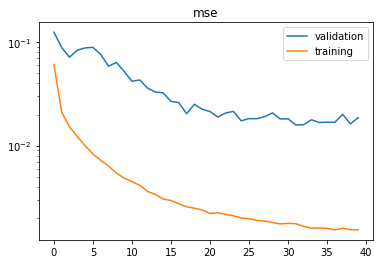

current model iteration =  105


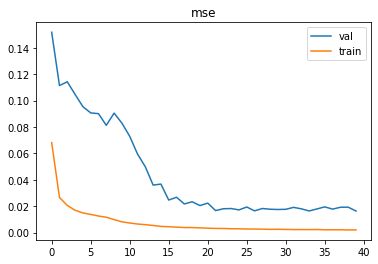

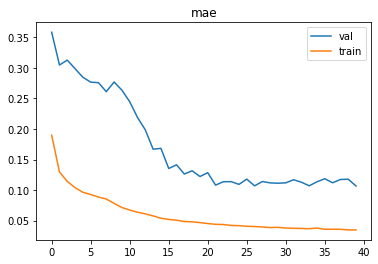

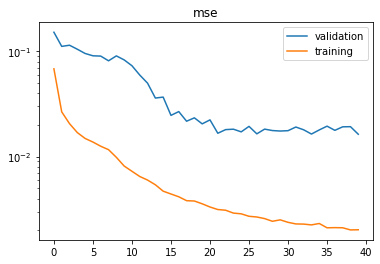

current model iteration =  106


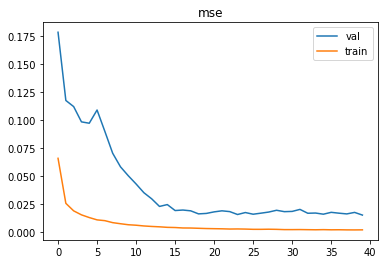

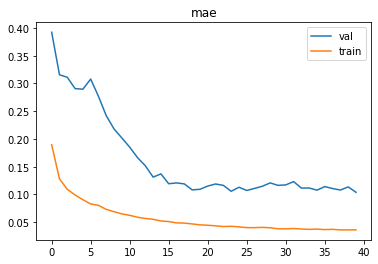

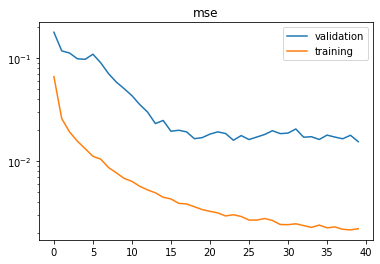

current model iteration =  107


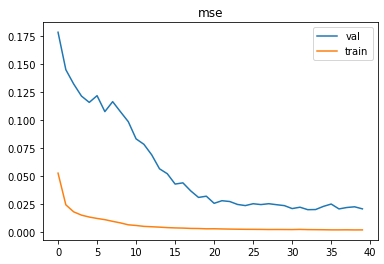

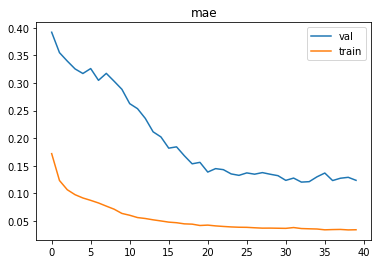

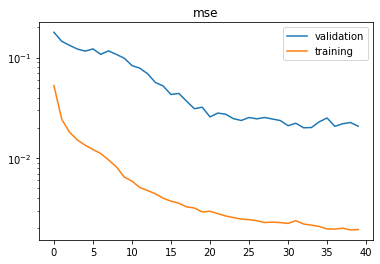

current model iteration =  108


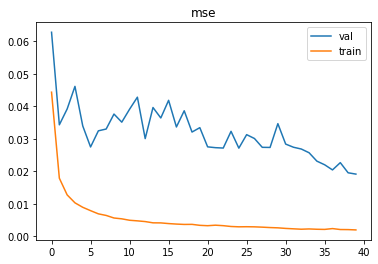

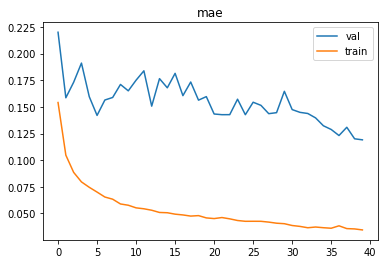

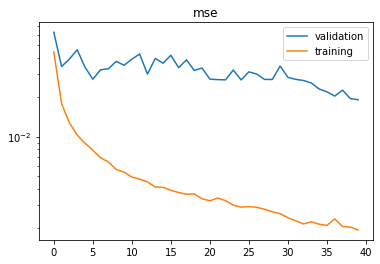

current model iteration =  109


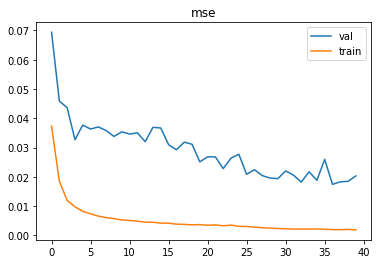

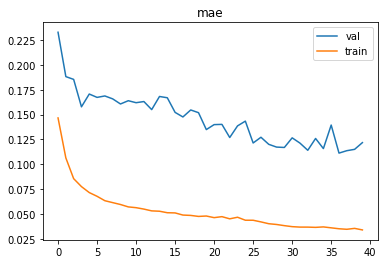

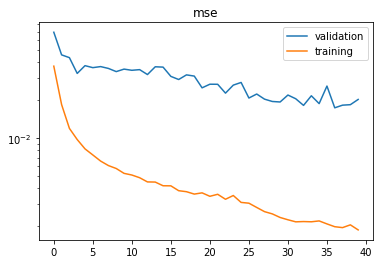

current model iteration =  110


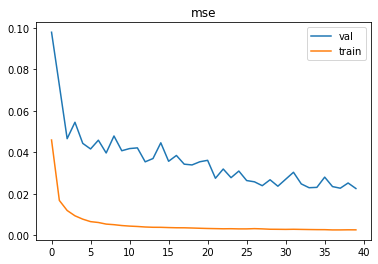

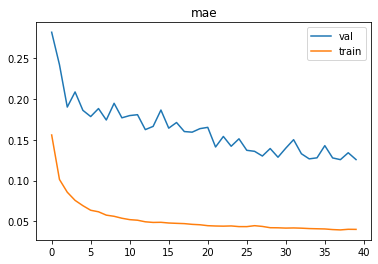

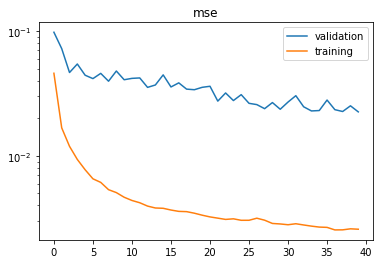

current model iteration =  111


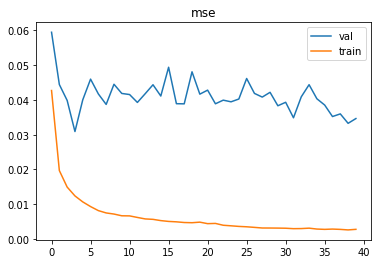

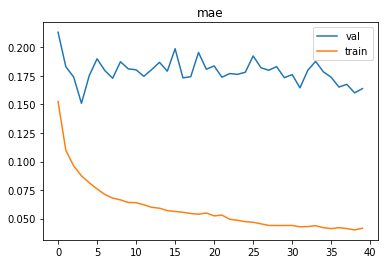

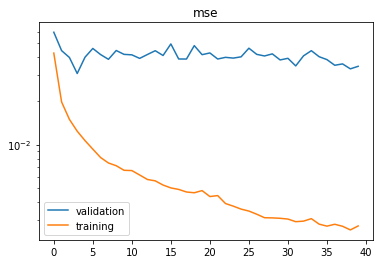

current model iteration =  112


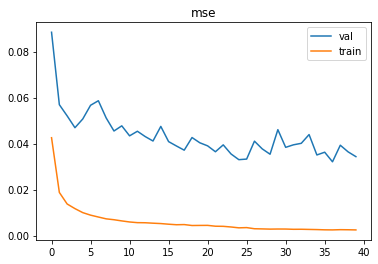

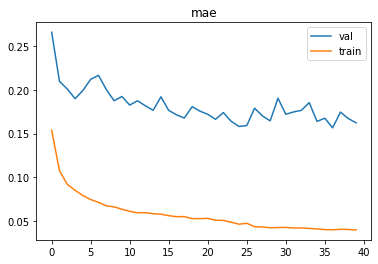

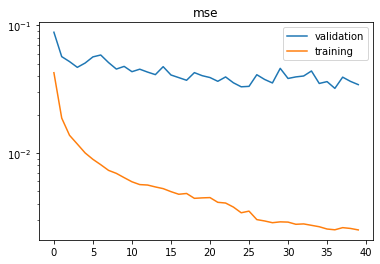

current model iteration =  113


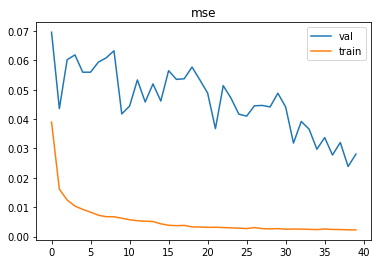

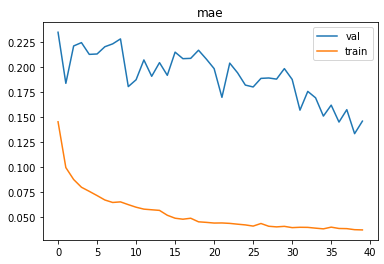

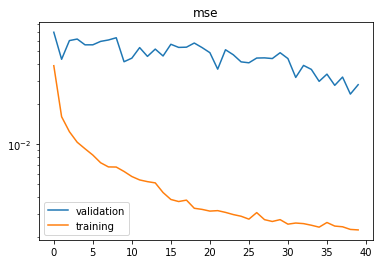

current model iteration =  114


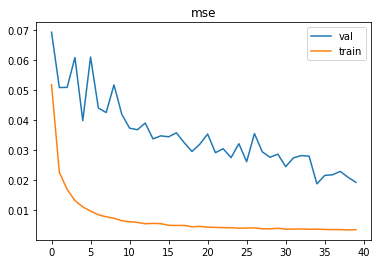

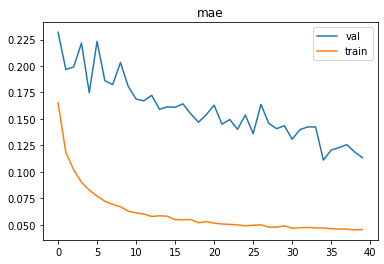

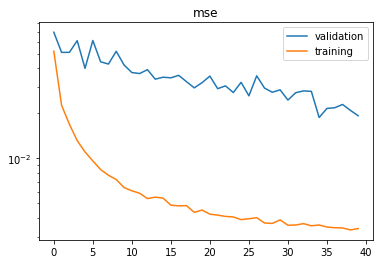

current model iteration =  115


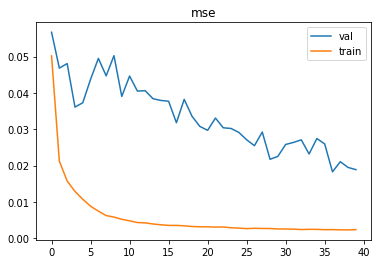

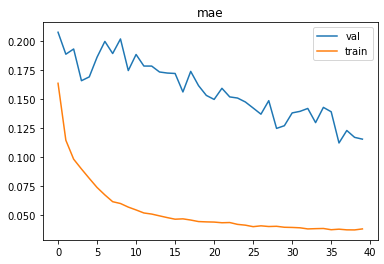

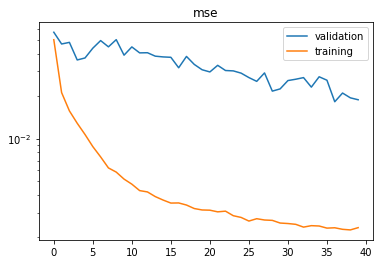

current model iteration =  116


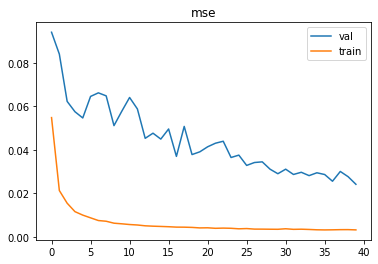

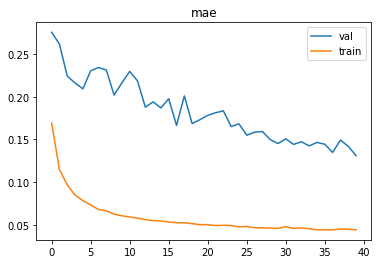

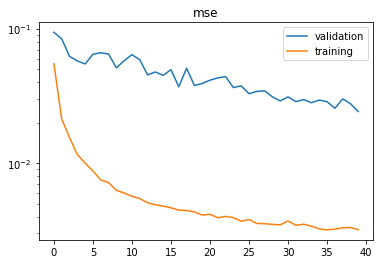

current model iteration =  117


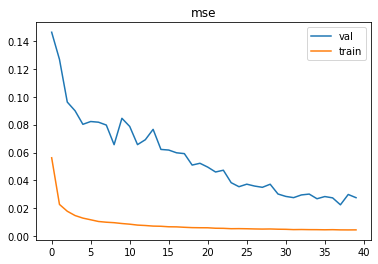

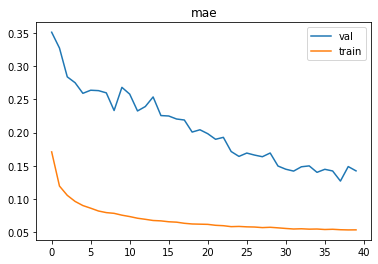

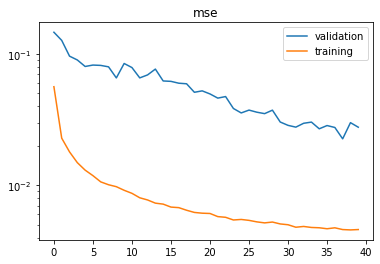

current model iteration =  118


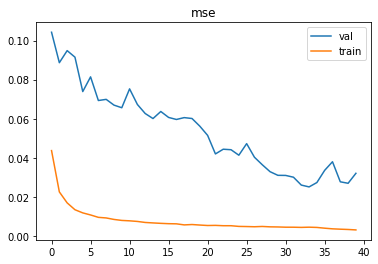

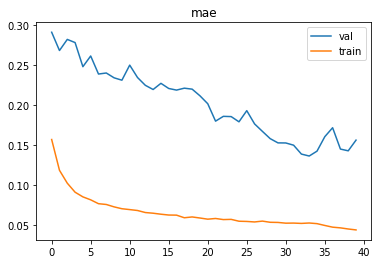

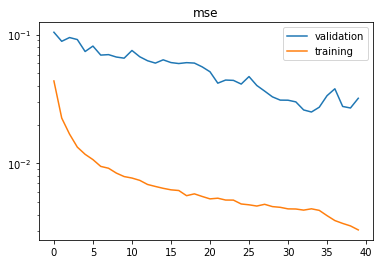

current model iteration =  119


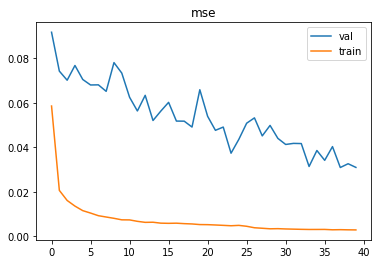

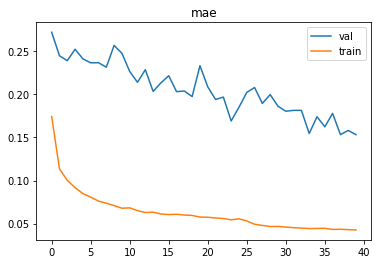

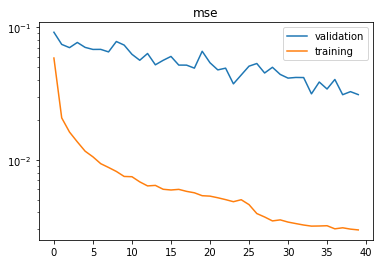

current model iteration =  120


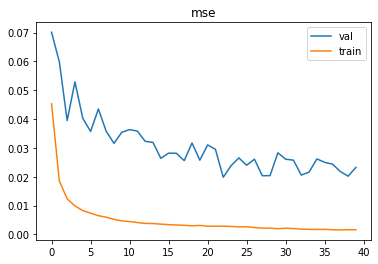

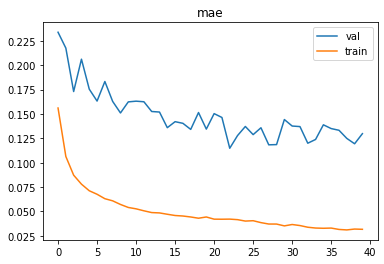

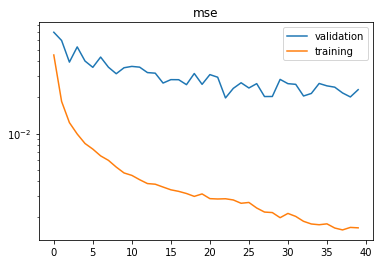

current model iteration =  121


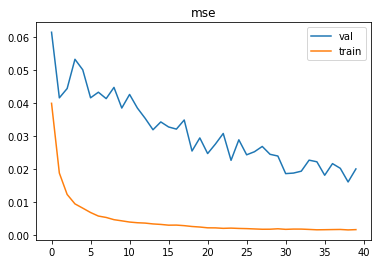

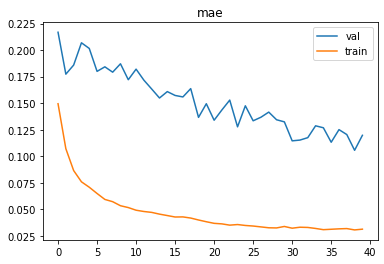

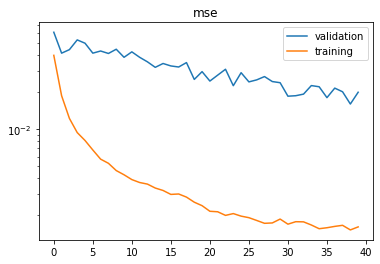

current model iteration =  122


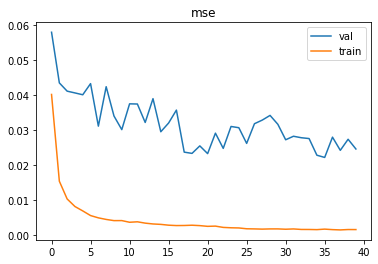

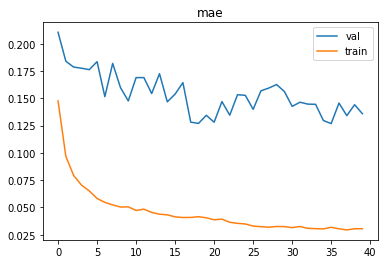

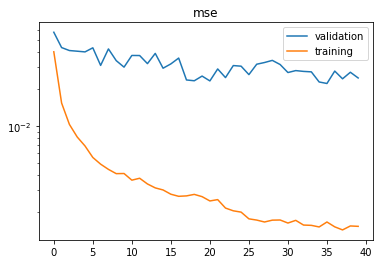

current model iteration =  123


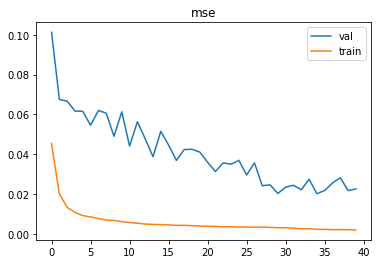

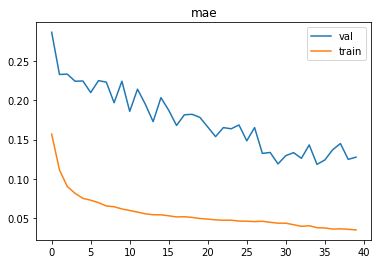

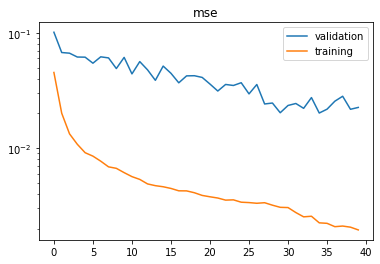

current model iteration =  124


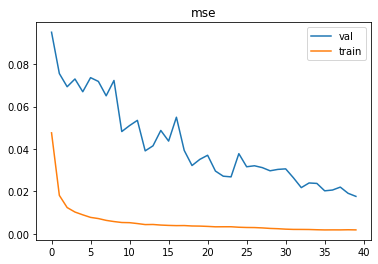

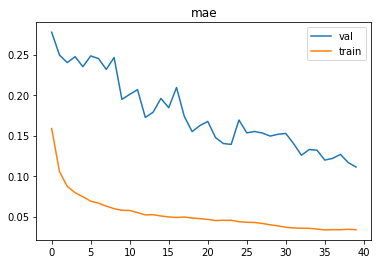

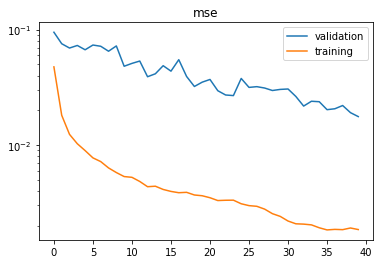

current model iteration =  125


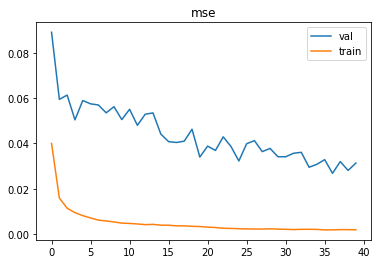

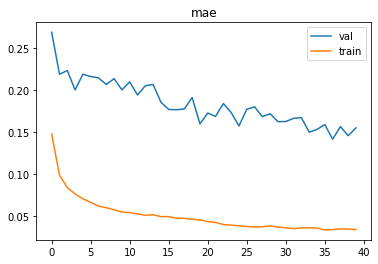

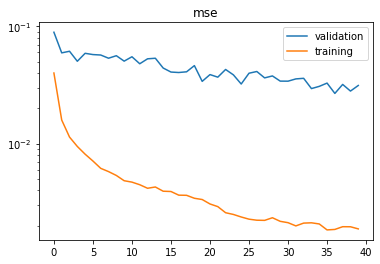

current model iteration =  126


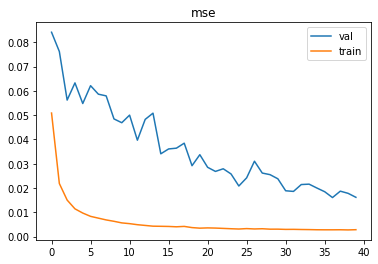

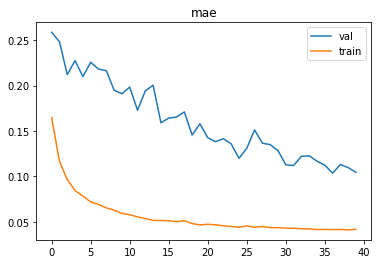

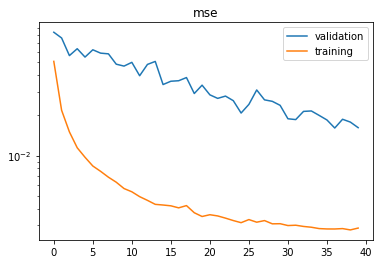

current model iteration =  127


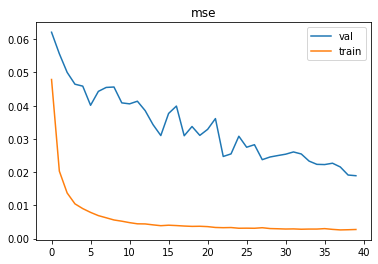

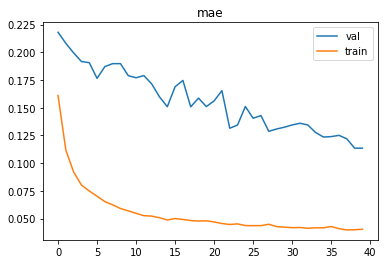

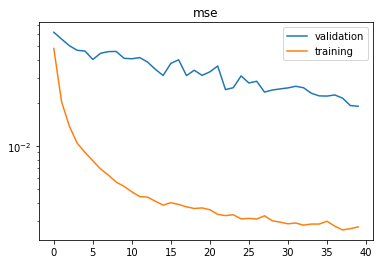

current model iteration =  128


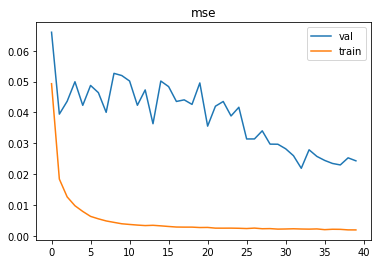

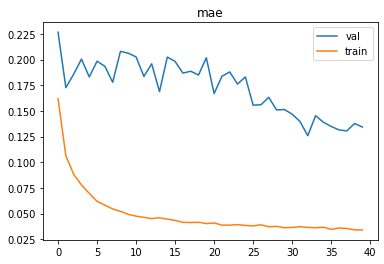

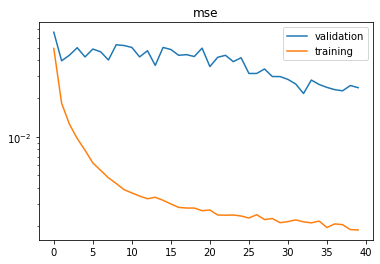

current model iteration =  129


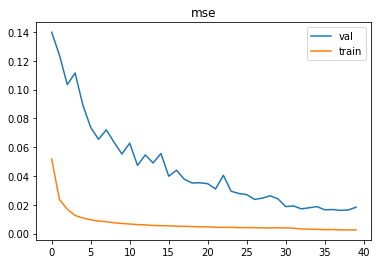

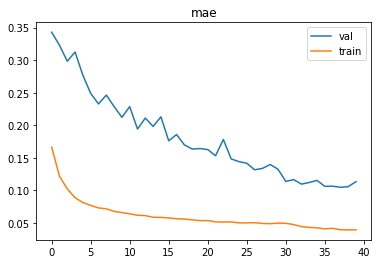

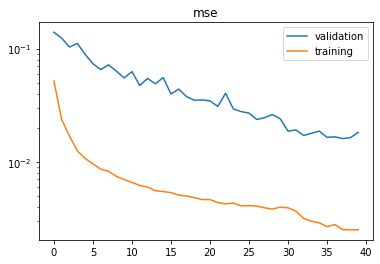

current model iteration =  130


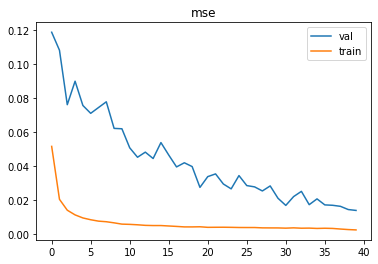

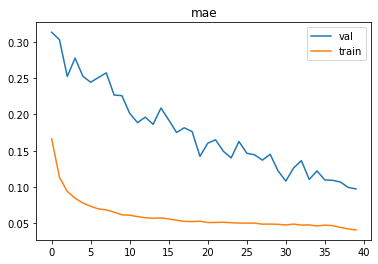

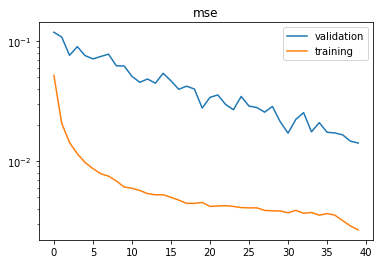

current model iteration =  131


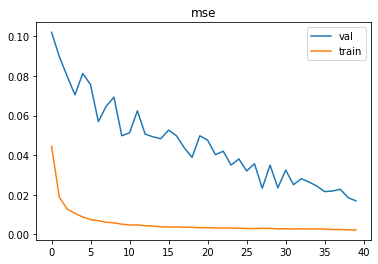

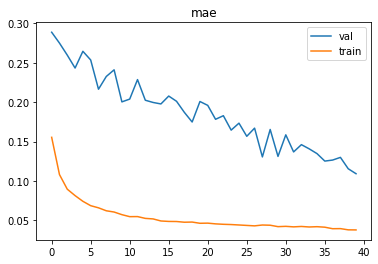

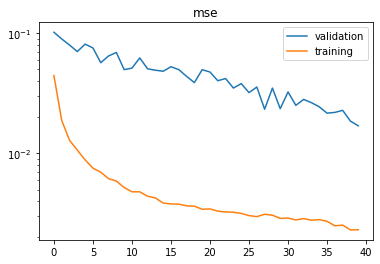

current model iteration =  132


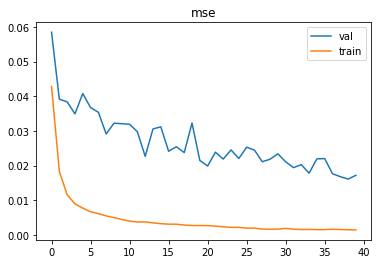

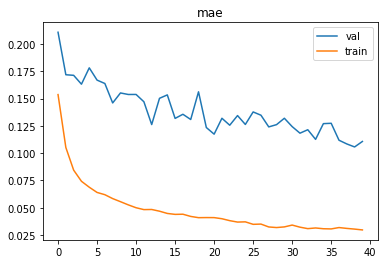

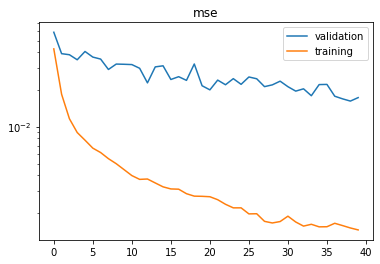

current model iteration =  133


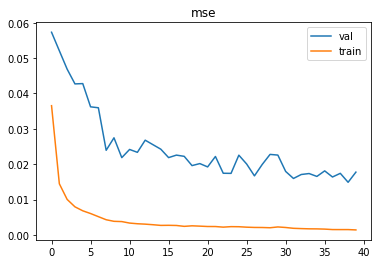

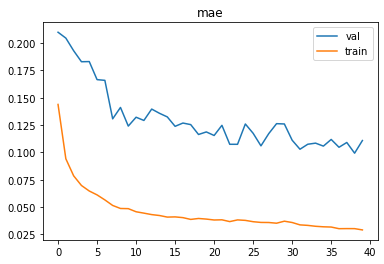

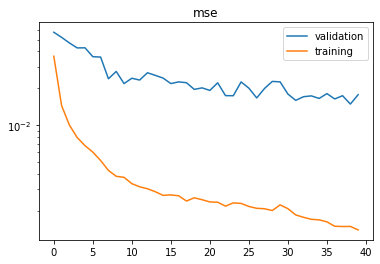

current model iteration =  134


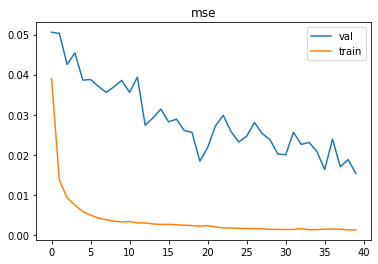

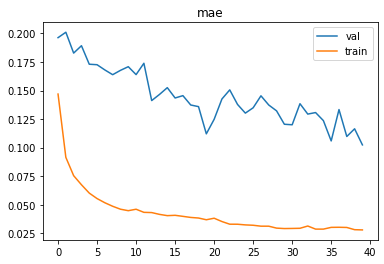

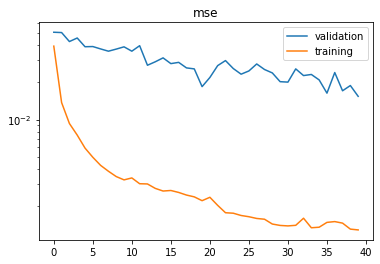

current model iteration =  135


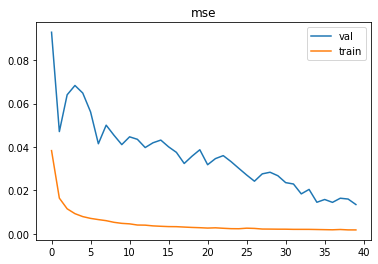

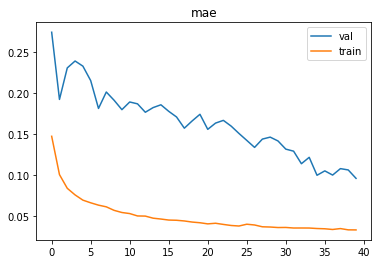

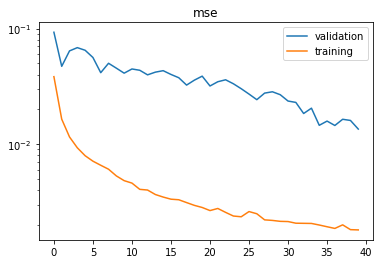

current model iteration =  136


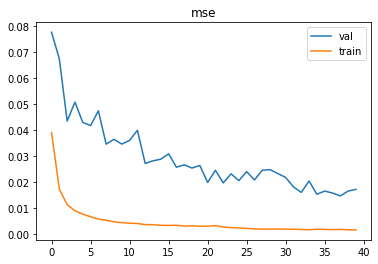

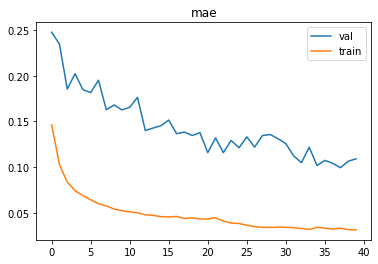

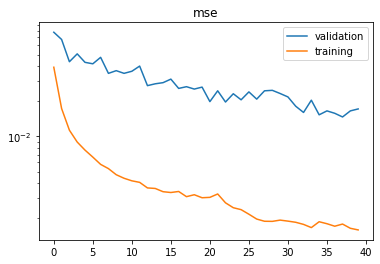

current model iteration =  137


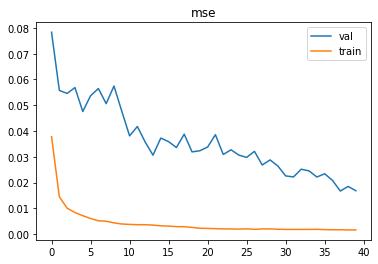

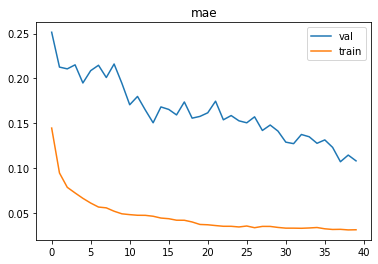

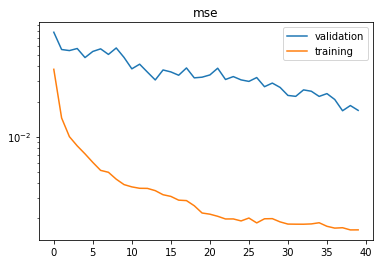

current model iteration =  138


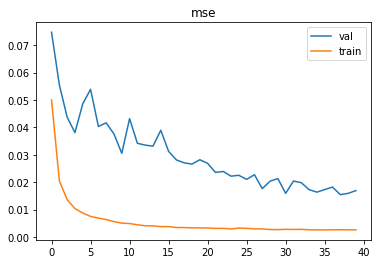

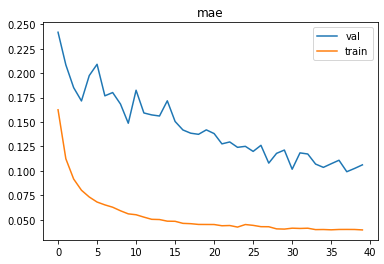

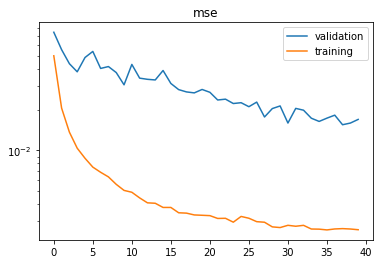

current model iteration =  139


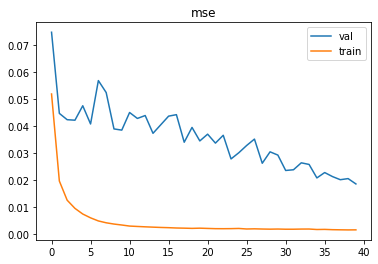

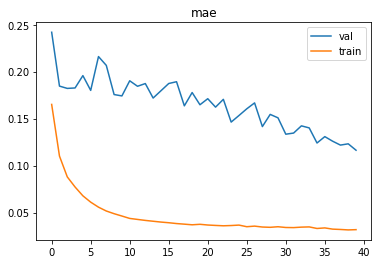

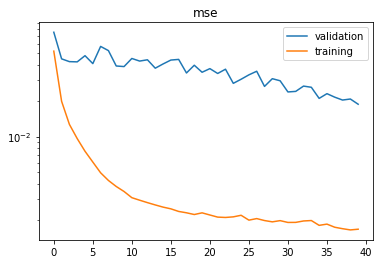

current model iteration =  140


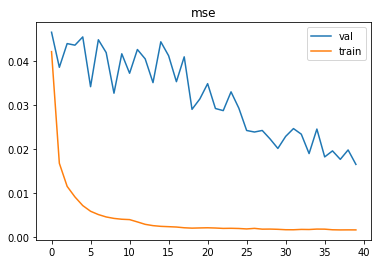

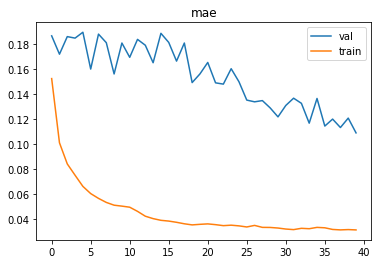

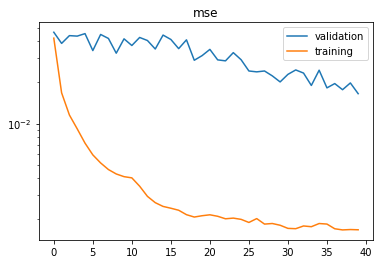

current model iteration =  141


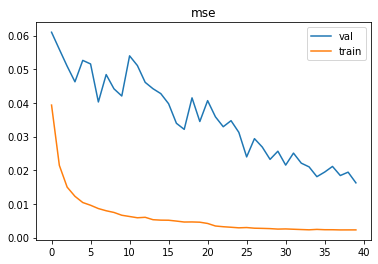

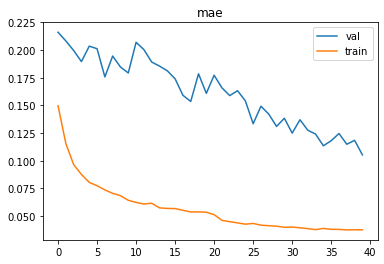

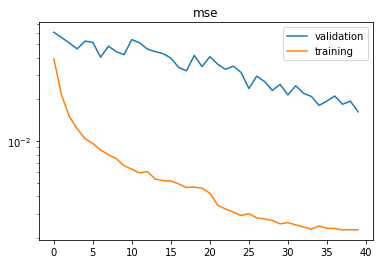

current model iteration =  142


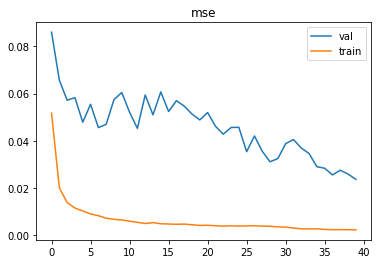

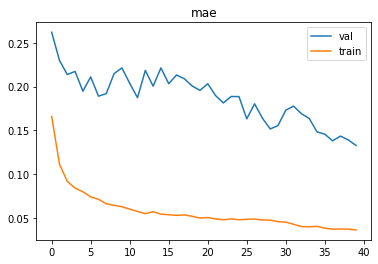

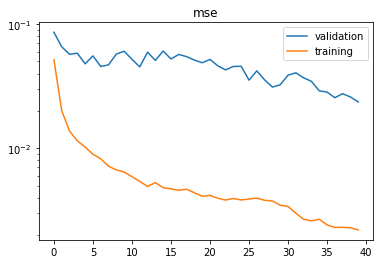

current model iteration =  143


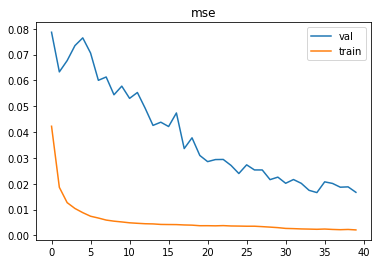

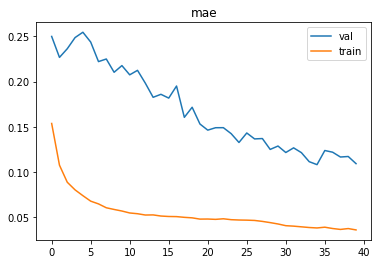

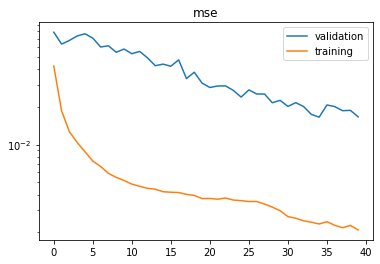

In [11]:
# notebook should likely be restarted after each run
K.clear_session()
build_test_run_models(epochs=40, 
                      batch_size=64, 
                      previous_completed_runs=0, 
                      dir_base='cnn_model_testing_01')

# Other things to consider
Quite honestly, other parameters that I could try tuning would be the min_df and max_df in count vectorizer, along with the number of terms I allow in there. Should probably make a function to run through whole data process for lstm

# Now to further check losses on best performing CNNs

models worth looking at
- 135, 143, 136, 131, 106, 105, 100, 12, 47, 51, 46, 60
- the tops are 46, 12, 51
    - the larger models have a larger gap between validation and training, but they have lower mses

## Time to explore these models further now

current model iteration =  0


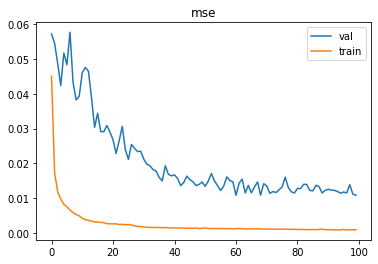

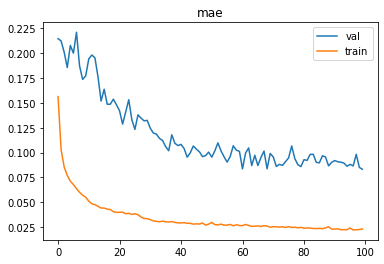

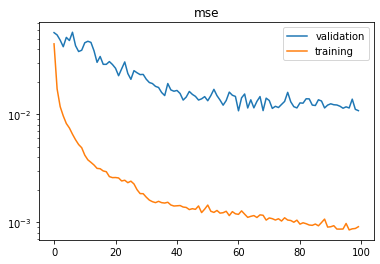

current model iteration =  1


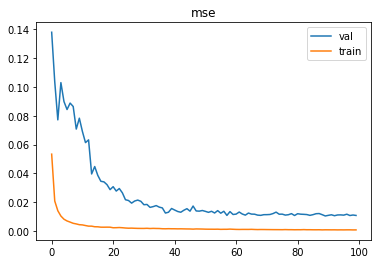

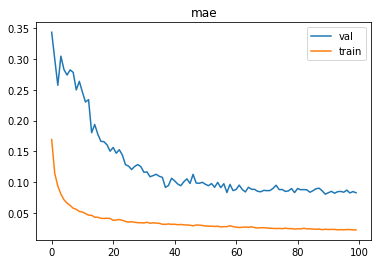

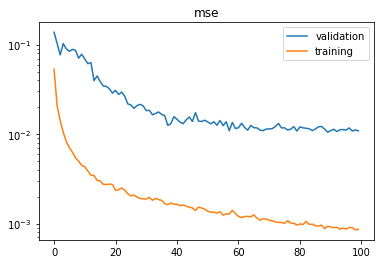

current model iteration =  2


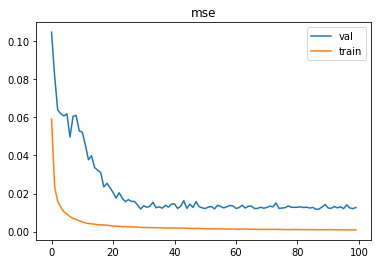

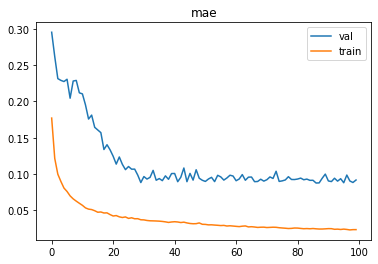

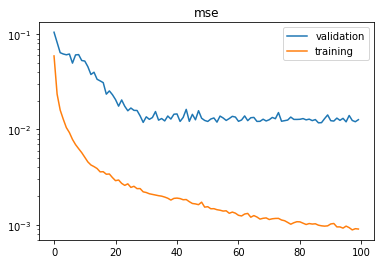

current model iteration =  3


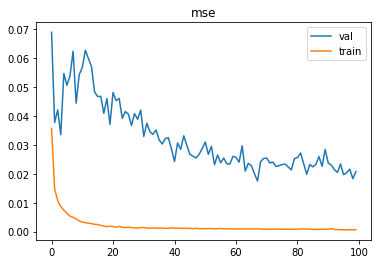

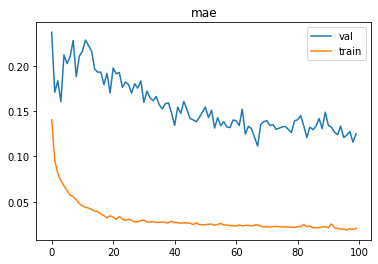

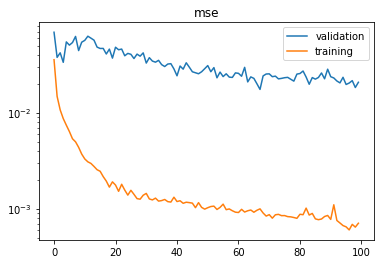

current model iteration =  4


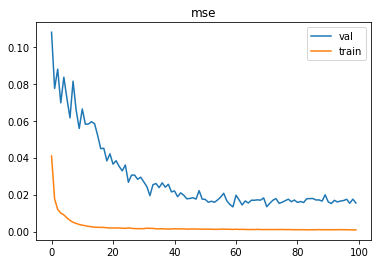

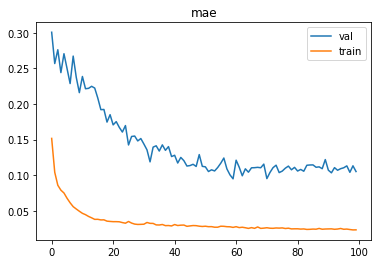

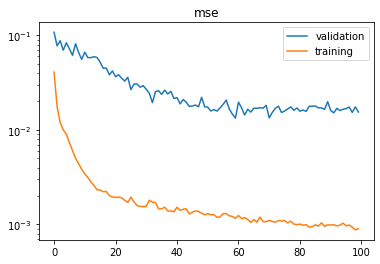

current model iteration =  5


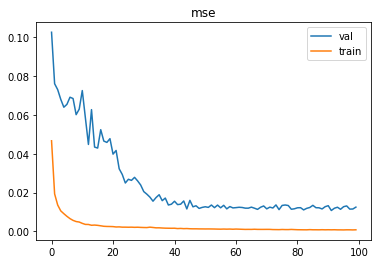

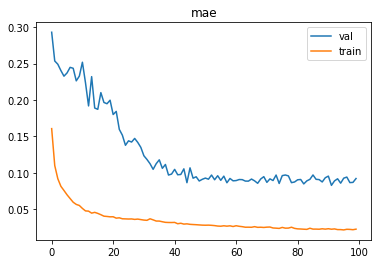

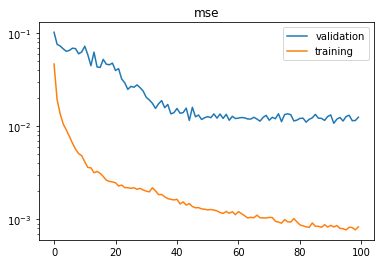

current model iteration =  6


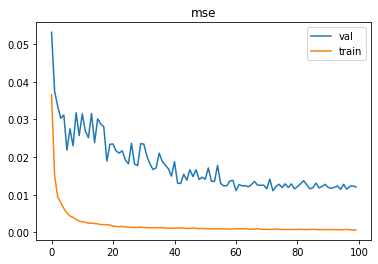

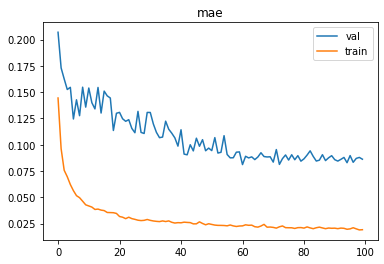

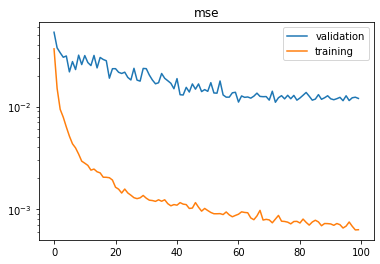

current model iteration =  7


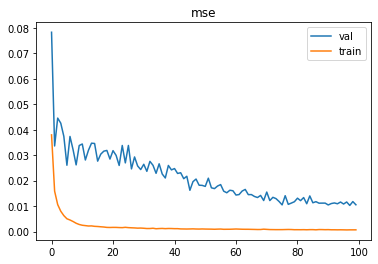

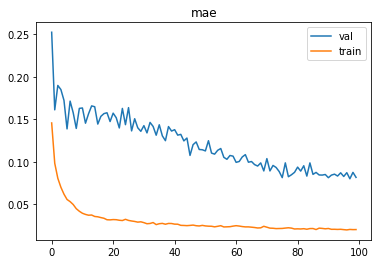

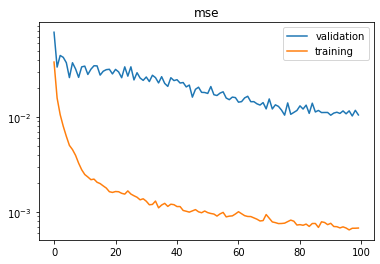

current model iteration =  8


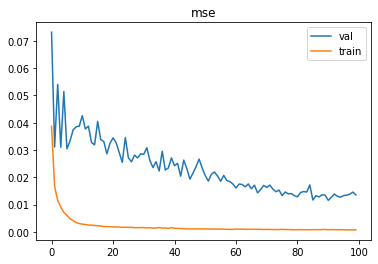

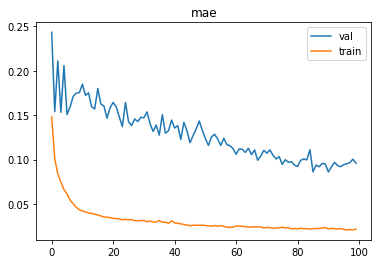

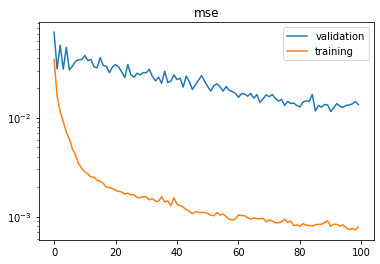

current model iteration =  9


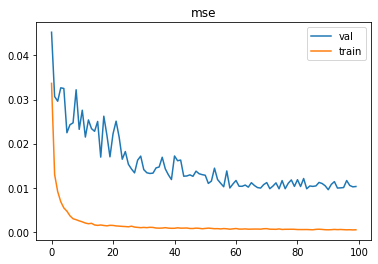

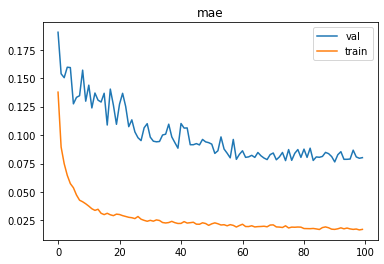

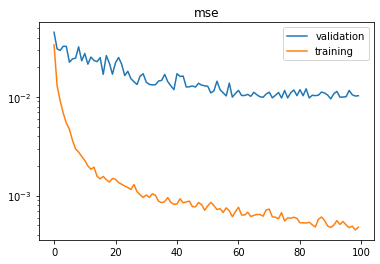

current model iteration =  10


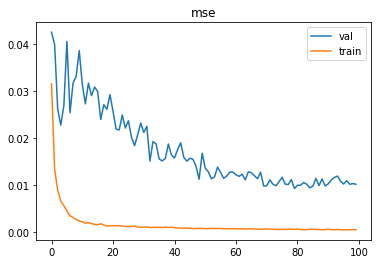

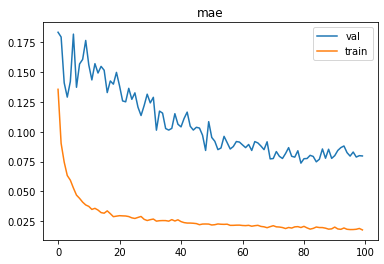

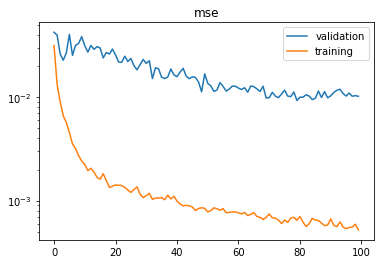

current model iteration =  11


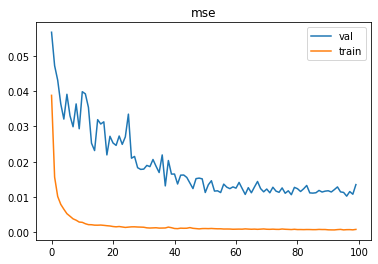

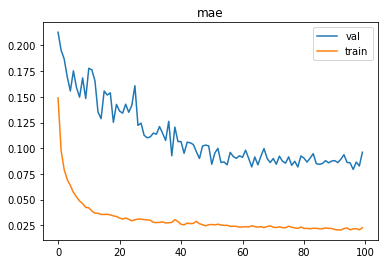

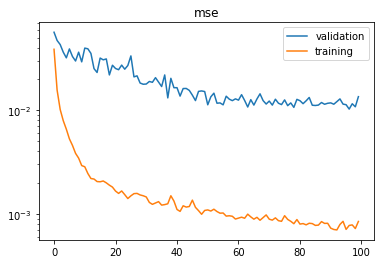

In [43]:
# training specific model
K.clear_session()
build_test_run_models(epochs=100, 
                      batch_size=64, 
                      previous_completed_runs=0, 
                      conv_units=[[32, 16, 8], [64, 32, 16], [32, 16], [64, 32]], 
                      output_dims=[32], 
                      kernel_sizes=[5], 
                      pool_sizes=[2, 3, 4], 
                      dropouts=[0.3], 
                      dir_base='cnn_model_06', 
                      save=True)

In [7]:
# load a model and evaluate stuff on it
loaded_cnn_model = keras.models.load_model('scoring_models/cnn_model_06_10.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
test_predictions = loaded_cnn_model.predict(data_valid_sequences)

In [9]:
print(mean_squared_error(y_pred=test_predictions, y_true=target_validation))
print(mean_absolute_error(y_pred=test_predictions, y_true=target_validation))

0.010466833011974428
0.08062798120851711


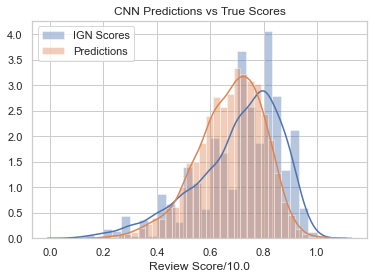

In [10]:
photo_dir = 'project_notes_or_data/photos_for_presentation/'
sns.distplot(target_validation, label='IGN Scores', axlabel='Review Score/10.0')
sns.distplot(test_predictions, label='Predictions')
plt.legend()
plt.title('CNN Predictions vs True Scores')
plt.savefig(photo_dir+'cnn_prediction_model_06_10.jpg', dpi=200)
plt.show()

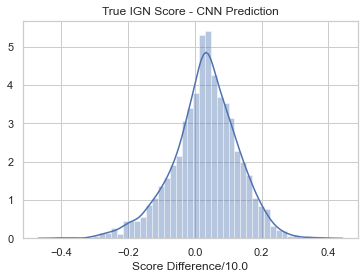

In [11]:
distance_from_score = target_validation - test_predictions[:,0]
sns.distplot(distance_from_score, axlabel='Score Difference/10.0')
plt.title('True IGN Score - CNN Prediction')
plt.savefig(photo_dir+'cnn_true_score_distance_06_10.jpg', dpi=200)
plt.show()

# print(target_validation)
# print(test_predictions[:,0])